In [9]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
import time
os.environ['HF_HOME'] = '/raid/xd/.cache/torch'
from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter, namedtuple
from datetime import datetime
from io import StringIO
from itertools import chain
import math
from functools import reduce, partial
from collections.abc import Iterable
import pickle, gzip

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader
import torch.optim as optim

# sys.path.insert(0, '/nas/xd/projects/transformers/src')
from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, pipeline
from transformers import RobertaForMaskedLM, RobertaTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM
from transformers import T5Tokenizer, T5ForConditionalGeneration

from transformers.models.gpt2.modeling_gpt2 import GPT2Attention
from transformers.models.gpt_neo.modeling_gpt_neo import GPTNeoSelfAttention
from transformers.models.gptj.modeling_gptj import GPTJAttention, GPTJBlock
from transformers.models.xglm.modeling_xglm import XGLMAttention

from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed
# from transformers.trainer_utils import EvaluationStrategy

In [11]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [12]:
import einops
from einops import rearrange

In [13]:
sys.path.insert(0, '/nas/xd/projects/pptree')
from pptree import Node, print_tree

In [26]:
from child_utils import *
from common_utils import *
from model_utils import *

In [16]:
models = {}
cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
proxies = {'http': '192.168.50.1:1081'} 

In [654]:
# model_name = "EleutherAI/gpt-neo-1.3B"
for model_name in ['gpt2-large', 
            'gpt2-xl', 'EleutherAI/gpt-neo-1.3B',  # = babbage
            'EleutherAI/gpt-j-6B', 'KoboldAI/fairseq-dense-6.7B', # = curie 
            'KoboldAI/fairseq-dense-13B']:
    if model_name not in models:
        with Timer(model_name):
            model = AutoModelForCausalLM.from_pretrained(model_name, cache_dir=cache_dir)  
            tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
            models[model_name] = model, tokenizer

gpt2-xl ... done 0:02:54
EleutherAI/gpt-neo-1.3B ... 

Downloading:   0%|          | 0.00/200 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

done 0:02:21
EleutherAI/gpt-j-6B ... done 0:09:32
KoboldAI/fairseq-dense-6.7B ... done 0:05:13
KoboldAI/fairseq-dense-13B ... 

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

done 0:09:43


In [338]:
model_name = 'gpt2-large'  # medium / large /xl
# model_name = 'EleutherAI/gpt-j-6B' # gpt-j-6B, gpt-neo-1.3B/2.7B
model, tokenizer = models[model_name]
_ = model.eval()

masked_lm = tokenizer.mask_token is not None and len(tokenizer.additional_special_tokens) == 0
if masked_lm:
    mask_token = tokenizer.mask_token  # '<mask>' for roberta
elif len(tokenizer.additional_special_tokens) > 0:
    mask_token = tokenizer.additional_special_tokens[0]  # '<extra_id_0>' for t5
else:
    mask_token = ''  # for gpt2
if masked_lm: nlp = pipeline('fill-mask', model=model, tokenizer=tokenizer, top_k=5)

Using mask_token, but it is not set yet.


In [361]:
unify(model)
blocks = model.transformer.h
attn = blocks[0].attn
ln_f = model.transformer.ln_f
L, H, embed_dim = len(blocks), attn.num_heads, attn.embed_dim

we = model.transformer.wte.weight.data.t()
wp = model.transformer.wpe.weight.t()
wu = model.lm_head.weight.data

In [16]:
def forward(model, inputs, labels=None, loss_reduction=None, by_head=False, attribute_layer=None, 
            head_mask=None, mlp_mask=None, attn_weights=None,
            hidden_states=None, detach_layer=None,
            special_head=(None, None), special_head_multiplier=1, wv=None, wo=None, 
            multiplied_layers=[], attr_threshold=1., base_multiplier=1.5):
    head_mask = fill_list(head_mask, L, attribute_layer)
    mlp_mask = fill_list(mlp_mask, L, attribute_layer)
    attn_weights = fill_list(attn_weights, L, attribute_layer)
    from_layer = attribute_layer if hidden_states is not None else None

    self = model.transformer
    (hidden_states, inputs_embeds, position_embeds) = embed_forward(self, inputs) \
        if from_layer is None else (hidden_states, None, None)
    all_hidden_states, intermediates, mlp_outputs = (), (), ()
    attn_fwd_outputs = []
    # hq_extra = None
    special_head_outputs = None
    for i, b in enumerate(self.h):
        if from_layer is not None and i < from_layer: continue
        if i == detach_layer: hidden_states = hidden_states.detach()
        all_hidden_states += (hidden_states,)
        hq = hk = hv = b.ln_1(hidden_states)
        # if hq_extra is not None: hq = b.ln_1(hidden_states + hq_extra)
        attn_fwd_output = attn_forward(b, hq, hk, hv, by_head=by_head or i in multiplied_layers or i == special_head[0],
                            compute_head_input=True, head_mask=head_mask[i], attn_weights=attn_weights[i])
        attn_fwd_outputs.append(attn_fwd_output)
        attn_output, aw, head_input, head_output = attn_fwd_output
        if i == special_head[0]:
            head_output = list(rearrange(head_output, 'b n i e -> n b i e'))  # nbie->n*bie
            # hq_extra = aw[:, special_head[1]] @ (hv @ wv @ wo) # bnij->bij,bje->bie
            # attn_output = attn_output + hq_extra
            head_output[special_head[1]] = head_output[special_head[1]] * special_head_multiplier
            special_head_outputs = torch.cat([special_head_outputs, head_output[special_head[1]]]) \
                if special_head_outputs is not None else head_output[special_head[1]] # sie, s in [1, 2] for 8-1, 12-10
            attn_output = sum(head_output)
        if i in multiplied_layers:
            multiplier = get_multiplier(b, hidden_states, aw, head_input, special_head_outputs, labels, L, H,
                attr_threshold=attr_threshold, base_multiplier=base_multiplier)
            attn_output = torch.einsum('bnie,ni->bie', head_output, multiplier)
        if not my_isinstance(b, GPTJBlock): hidden_states = hidden_states + attn_output
        mlp_output, intermediate = mlp_forward(b, hidden_states, output_intermediate=True)
        if mlp_mask[i] is not None: mlp_output = einsum('bie,bi->bie', mlp_output, mlp_mask[i])
        intermediates += (intermediate,)
        mlp_outputs += (mlp_output,)
        if my_isinstance(b, GPTJBlock): hidden_states = hidden_states + attn_output
        hidden_states = hidden_states + mlp_output
    attn_outputs, all_attentions, head_inputs, head_outputs = zip(*attn_fwd_outputs)
    all_hidden_states += (hidden_states,) # both before and after ln_f
    hidden_states = self.ln_f(hidden_states)
    all_hidden_states += (hidden_states,)

    logits = model.lm_head(hidden_states)
    loss = compute_loss(logits, labels, reduction=loss_reduction) if labels is not None else None
    return Outputs(
        inputs_embeds=inputs_embeds, position_embeds=position_embeds,
        attn_outputs=attn_outputs, head_inputs=head_inputs, head_outputs=head_outputs, 
        intermediates=intermediates, mlp_outputs=mlp_outputs,
        hidden_states=all_hidden_states, attentions=all_attentions, 
        logits=logits, loss=loss,
    )

In [165]:
a = o.attentions[12][0, 10]
sim = torch.einsum('lhij->lh', (torch.cat(o.attentions) + 1e-9).log() * a * torch.ones_like(a).tril())

In [ ]:
list(zip(*topk_md(sim, 10)))

In [ ]:
l = 10
for text, examples, inputs, tokens, bos_indices, eos_indices, answers, labels, o, attn_attr in data_tuples[:1]:
    for k in range(H // 4):
        # print(layer, k * 2, k * 2 + 1)
        fig, axs = plt.subplots(1, 4, sharex=False, sharey=False, figsize=(20, 5))
        h = k * 4 + 0; plot_attn(o.attentions[l][0, h], tokens, ax=axs[0])
        h = k * 4 + 1; plot_attn(o.attentions[l][0, h], tokens, ax=axs[1])
        h = k * 4 + 2; plot_attn(o.attentions[l][0, h], tokens, ax=axs[2])
        h = k * 4 + 3; plot_attn(o.attentions[l][0, h], tokens, ax=axs[3])

In [766]:
for data_tuple in data_tuples:
    text, examples, inputs, tokens, bos_indices, eos_indices, answers, labels = data_tuple[:8]
    print(text)
    with torch.no_grad():
        o = forward(model, inputs, labels=labels, by_head=True)
        # so = sum_forward(model, o, reduce_fn=torch.cat, reshape=True)
    loss, _ = show_predictions(text, examples, tokenizer, o.logits, bos_indices, eos_indices, answers, labels, 
                    topk=3, loss_reduction='mean', show_range=range(k_shot, len(examples)), sep='\t')
    print(loss)
    attn_attr = {}
    del data_tuple[8:]
    data_tuple += [o, attn_attr]


five -> four
D -> C
eight -> seven
Thursday -> Wednesday
F -> E
three -> two
c -> b
June -> May
seven -> six
February -> January
3 -> 2
August -> July

* six 0.785 {' six': 0.785, ' five': 0.111, ' four': 0.044} 	 seven -> six
* January 0.356 {' January': 0.356, ' December': 0.295, ' October': 0.086} 	 February -> January
* 2 0.649 {' 2': 0.649, ' two': 0.107, ' 1': 0.042} 	 3 -> 2
* July 0.716 {' July': 0.716, ' August': 0.146, ' June': 0.083} 	 August -> July
tensor(0.5101)

Thursday -> Wednesday
F -> E
five -> four
c -> b
C -> B
b -> a
E -> D
October -> September
f -> e
d -> c
4 -> 3
April -> March

  e 0.058 {' g': 0.23, ' G': 0.128, ' d': 0.068} 	 f -> e
  c 0.169 {' a': 0.204, ' b': 0.171, ' c': 0.169} 	 d -> c
* 3 0.41 {' 3': 0.41, ' b': 0.067, ' d': 0.067} 	 4 -> 3
* March 0.635 {' March': 0.635, ' December': 0.071, ' January': 0.069} 	 April -> March
tensor(1.4916)

Wednesday -> Tuesday
Friday -> Thursday
August -> July
six -> five
3 -> 2
June -> May
four -> three
C -> B
Satu

## Amplification

In [620]:
def test(model, data_tuples, verbose=False, **kwargs):
    losses = []
    for data_tuple in data_tuples[:]:
        text, examples, inputs, tokens, bos_indices, eos_indices, answers, labels, o, attn_attr = data_tuple[:]
        loss, _ = show_predictions(text, examples, tokenizer, o.logits, bos_indices, eos_indices, answers, labels, 
                    topk=3, loss_reduction='mean', show_range=range(k_shot, len(examples)), sep='\t', verbose=verbose)
        if verbose: print('loss =', loss)
        
        from_layer, _ = kwargs['special_head']  # 12
        hidden_states = o.hidden_states[from_layer]
        o2 = forward(model, inputs, labels=labels, attribute_layer=from_layer, hidden_states=hidden_states, **kwargs)
        loss2, _ = show_predictions(text, examples, tokenizer, o2.logits, bos_indices, eos_indices, answers, labels, 
                    topk=3, loss_reduction='mean', show_range=range(k_shot, len(examples)), sep='\t', verbose=verbose)
        if verbose: print('loss2 =', loss2, '\n')
        losses.append(loss2.item())
    losses = torch.Tensor(losses)
    print('losses =', losses)
    return losses.mean()

In [ ]:
12-10*3,
0.47

12-10*3, threshold=5., base_multiplier=1.5
tensor([0.0230, 0.0119, 1.2052, 0.2945, 0.0157, 0.0597, 0.0702, 0.5085, 0.2899,
        0.0326, 0.0408, 1.1831, 0.0516, 0.6363, 0.5234, 2.5790, 0.0979, 0.5943])
tensor(0.4565)
12-10*3, threshold=3., base_multiplier=1.5
tensor([0.0227, 0.0109, 1.2108, 0.2642, 0.0151, 0.0506, 0.0595, 0.5087, 0.3540,
        0.0263, 0.0336, 1.1175, 0.0426, 0.7020, 0.5188, 2.5127, 0.0997, 0.4610])
tensor(0.4450)
12-10*3, threshold=1., base_multiplier=1.5
tensor([0.0216, 0.0131, 1.2596, 0.3078, 0.0212, 0.0453, 0.0745, 0.7034, 0.2971,
        0.0242, 0.0579, 0.9990, 0.0391, 0.7800, 0.4985, 2.7309, 0.1179, 0.4555])
tensor(0.4693)

12-10*1, threshold=5., base_multiplier=1.5
tensor([0.0280, 0.0179, 1.5402, 0.6329, 0.0368, 0.1095, 0.1551, 0.9999, 0.4408,
        0.0323, 0.0402, 0.8825, 0.0553, 0.5654, 0.6607, 2.1981, 0.1345, 0.7474])
tensor(0.5154)
12-10*1, threshold=10., base_multiplier=1.5
tensor([0.0276, 0.0188, 1.5444, 0.5967, 0.0475, 0.0998, 0.1569, 1.0300, 0.4510,
        0.0330, 0.0390, 0.8318, 0.0685, 0.6363, 0.7036, 2.2156, 0.1415, 0.7441])
tensor(0.5214)
12-10*1, threshold=10., base_multiplier=2.0
tensor([0.0272, 0.0174, 1.5211, 0.5767, 0.0467, 0.0894, 0.1517, 0.9618, 0.4449,
        0.0375, 0.0390, 0.8318, 0.0626, 0.6357, 0.7095, 2.2156, 0.1410, 0.7165])
tensor(0.5126)

12-10*3, threshold=5., base_multiplier=1.5 opt
tensor([0.0239, 0.0128, 1.1290, 0.2517, 0.0170, 0.0526, 0.0707, 0.5806, 0.3219,
        0.0238, 0.0440, 0.9224, 0.0427, 0.7748, 0.5562, 2.6125, 0.1175, 0.4395])
tensor(0.4441)

8-1*1, threshold=5., base_multiplier=1.5 opt
tensor([0.0287, 0.0160, 1.5901, 0.6175, 0.0296, 0.0746, 0.1242, 0.9194, 0.5042,
        0.0330, 0.0492, 0.7875, 0.0552, 0.6154, 0.6522, 2.2360, 0.1363, 0.6757])
tensor(0.5080)

In [ ]:
test(model, data_tuples, special_head=(12, 10), wv=wv1, wo=wo1*0, special_head_multiplier=2.,
    multiplied_layers=range(13, L), attr_threshold=5., base_multiplier=1.5, verbose=True)

In [635]:
def get_multiplier(block, hidden_states, attentions, head_input, special_head_output, labels, L, H, attr_threshold=1, base_multiplier=1.5, verbose=False):
    # mask = torch.ones(1, H, L, H + 2, outputs.cat_hidden_states.size(-2)); mask[:, :, layer:] = 0 # bnloi
    # x = {'mask': mask}
    
    # special_head_output: sie
    x = {'mask': torch.ones(1, H, special_head_output.size(0) + 1, special_head_output.size(-2))}  # bnpi

    attn_labels = torch.einsum('bnij,bnj->bnij', attentions, head_input.norm(dim=-1)) # bnje->bnj
    # attn_labels = attn_labels / attn_labels.sum(-1, keepdim=True)  # bnij->bni1 
    fwd_fn = partial(cat_attn_forward, cat_hidden_states=special_head_output, #outputs.cat_hidden_states, 
                sum_hidden_states=hidden_states, attn_labels=attn_labels)
    attr, ys, logits = _attribute(fwd_fn, block, x, num_points=3)
    # print(ys)

    a = attr['mask']  # nloi, nsi
    # a2 = torch.add(a[:, 8, 1, :]*0, a[:, 12, 10, :]) # ni
    a2 = a[:, -1, :]  # ni

    labels_mask = (labels != -100).squeeze(0)#.fill_(1)
    multiplier_mask = (a2 >= attr_threshold) * labels_mask
    if verbose and multiplier_mask.sum() > 0:
        for head in range(H):
            n_multiplied = multiplier_mask[head].sum()
            if n_multiplied > 0:
                print(f'{layer}-{head}', n_multiplied, (a2 * labels_mask)[head].topk(min(a2.size(1), n_multiplied + 1)))
    return base_multiplier * multiplier_mask + 1 * ~multiplier_mask

In [ ]:
label_mask = (labels != -100).squeeze(0)#.fill_(1)
for layer in range(13, L):
    block = blocks[layer]
    mask = torch.ones(1, H, L, H + 2, o.cat_hidden_states.size(-2)); mask[:, :, layer:] = 0 # bnloi
    x = {'mask': mask}  
    attn_labels = torch.einsum('bnij,bnj->bnij', o.attentions[layer],
                    o.head_inputs[layer].norm(dim=-1)) # bnje->bnj
    attn_labels = attn_labels / attn_labels.sum(-1, keepdim=True)  # bnij->bni1
    fwd_fn = partial(cat_attn_forward, cat_hidden_states=o.cat_hidden_states, 
                sum_hidden_states=o.hidden_states[layer], attn_labels=attn_labels)
    attr, ys, logits = _attribute(fwd_fn, block, x, num_points=3)
    # print(ys)

    a = attr['mask']  # nloi
    # a = a[:, :, :, label_mask] # nloi->nlok
    a2 = torch.add(a[:, 8, 1, :], a[:, 12, 10, :]) # nk
    if a2[:, label_mask].max() > 1:
        print('layer', layer)
        _a2 = a2.clone(); _a2[0, 0] = 1; _ = sns.heatmap(_a2 * (_a2 >= 1) * label_mask); plt.show()
        print((_a2 * (_a2 >= 1) * label_mask).view(-1).topk(5)[0])
        for head in range(H):
            if a2[head].max() > 1:
                print(f'{layer}-{head}')
                plot_attn(o.attentions[layer][0, head], tokens); plt.show()

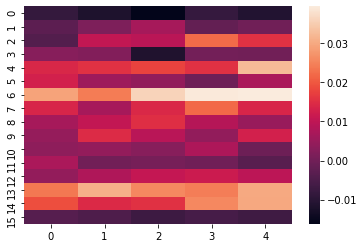

In [ ]:
a = attr['mask']  # nloi
a = a[:, :, :, (labels != -100).squeeze(0)] # nloi->nlok
ratio = ((a[:, 8, 1, :] + a[:, 12, 10, :]) / torch.einsum('nlok->nk', a.abs()))
b = einops.reduce(a, 'n l o k -> n k', 'max') == torch.maximum(a[:, 8, 1, :], a[:, 12, 10, :])
_ = sns.heatmap(ratio)
head_output_norm = o.head_outputs[layer][0, :, (labels != -100).squeeze(0)].norm(dim=-1)
_ = sns.heatmap(head_output_norm)

K-composition: $\text{Id} \otimes A^{h_{-1}} \otimes (W_E^T W_{QK}^h W_{OV}^{h_{-1}} W_E)$, measured by Frobenius norm ratio:  
$||W_{QK}^{h_2}W_{OV}^{h_1}||_F \mathbin{/} (||W_{QK}^{h_2}||_F ||W_{OV}^{h_1}||_F)$

$||W_{QK}^{h_2}W_{OV}^{h_1}W_{OV}^{h_0}||_F \mathbin{/} (||W_{QK}^{h_2}||_F ||W_{OV}^{h_1}||_F ||W_{OV}^{h_0}||_F)$

In [140]:
def v_comp(WOV, l0, h0, l1, h1): return ((WOV[l1][h1] @ WOV[l0][h0]).norm() / WOV[l1][h1].norm() / WOV[l0][h0].norm()).item()
def q_comp(WQK, WOV, l0, h0, l1, h1): return ((WQK[l1][h1] @ WOV[l0][h0]).norm() / WQK[l1][h1].norm() / WOV[l0][h0].norm()).item()
def vq_comp(WQK, WOV, l0, h0, l1, h1, l2, h2):
    return ((WQK[l2][h2] @ WOV[l1][h1] @ WOV[l0][h0]).norm() / WQK[l2][h2].norm() / WOV[l1][h1].norm() / WOV[l0][h0].norm()).item()

In [ ]:
WQK = [[combine_weights(get_head_weights(model, l, h), qk=True) for h in range(H)] for l in tqdm(range(L))]
WOV = [[combine_weights(get_head_weights(model, l, h), qk=False) for h in range(H)] for l in tqdm(range(L))]
WQKN = [[WQK[l][h].norm() for h in range(H)] for l in tqdm(range(L))]
WOVN = [[WOV[l][h].norm() for h in range(H)] for l in tqdm(range(L))]

In [ ]:
vq_comps = np.zeros((H, H))
nvq_comps = np.zeros((H, H))
l1, h1 = 12, 10
for l0 in range(3, 4):
    for h0 in tqdm(range(H)):
        # print(f'{l0}-{h0}', end=' ')
        wov01 = WOV[l1][h1] @ WOV[l0][h0]
        # norm01 = WOV[l1][h1].norm() * WOV[l0][h0].norm()
        norm01 = WOVN[l1][h1] * WOVN[l0][h0]
        for l2 in range(13, 14):
            for h2 in range(H):
                vq_comps[h0, h2] = (WQK[l2][h2].T @ wov01).norm() #/ WQKN[l2][h2] / norm01
                nvq_comps[h0, h2] = vq_comps[h0, h2] / WQKN[l2][h2] / norm01
    # print()
tensor = torch.Tensor(vq_comps)
values, indices = tensor.flatten().topk(10)
list(zip(values, *np.unravel_index(indices.numpy(), tensor.shape)))

## Head geometry visualization

In [15]:
def add_ws(model, ws, w2i, w_type, start_layer, end_layer, H):
    offset = len(w2i)
    dL = end_layer - start_layer
    n_ws = dL * H
    w_types = [w_type] * n_ws
    layers, heads = np.unravel_index(range(n_ws), (dL, H))
    layers = layers + start_layer
    w2i.update(OrderedDict(zip(
        zip(w_types, layers, heads),  # key, e.g. ('o', 2, 11)
        range(offset, offset + n_ws))))  # value, e.g. 0+43
    w_idx, transpose = ['q', 'k', 'v', 'o'].index(w_type), w_type == 'o'
    _ws = torch.cat([get_head_weights(model, l, transpose=transpose)[w_idx] for l in range(start_layer, end_layer)])  # l*nde->(ln)de
    ws = _ws if ws is None else torch.cat([ws, _ws])
    return ws, w2i

In [369]:
ws, w2i = None, OrderedDict()
ws, w2i = add_ws(model, ws, w2i, 'o', 0, 13+1, H)
ws, w2i = add_ws(model, ws, w2i, 'q', 9, L, H)
ws, w2i = add_ws(model, ws, w2i, 'v', 8, 13+1, H)

In [370]:
_distance, distance = get_affinities(ws, ws)
tsne = TSNE(n_components=2, metric='precomputed')
result = tsne.fit_transform(_distance)

In [ ]:
# _ = plt.figure(figsize=(20, 10))
fig, ax = plt.subplots(figsize=(20, 10))

for cond, color in [([i for (m_type, l, h), i in w2i.items() if m_type == 'o' and l < 8], 'g'),
                    ([i for (m_type, l, h), i in w2i.items() if m_type == 'q' and 12 < l < 24], 'r')]:
    _ = plt.scatter(x=result[:, 0][cond], y=result[:, 1][cond], marker='.', color=color)
# _ = ax.scatter(x=result[:, 0], y=result[:, 1], marker='.')

for w_type, l, h in [('v', 12, 10), ('v', 8, 1), ('v', 8, 0), ('v', 8, 15), ('v', 11, 1),
                    ('o', 12, 10), ('o', 8, 1), ('o', 8, 0), ('o', 8, 15), ('o', 11, 1)]:
    i = w2i[(w_type, l, h)]
    _ = ax.annotate(f'{w_type}-{l}-{h}', (result[i, 0], result[i, 1]), color='g' if w_type == 'v' else 'r')

## Affinity analysis

In [440]:
with torch.no_grad(): eigv_positivity_ov, eigv_positivity_qk = compute_eigv_positivity(model, L, H)

100%|██████████| 36/36 [01:05<00:00,  1.83s/it]


In [444]:
# np.savez('eigv_positivity_gpt2-large.npz', ov=eigv_positivity_ov.numpy(), qk=eigv_positivity_qk.numpy())
data = np.load('eigv_positivity_gpt2-large.npz')
eigv_positivity_ov, eigv_positivity_qk = torch.Tensor(data['ov']), torch.Tensor(data['qk'])
eigv_positivity = rearrange([torch.Tensor(data['qk']), torch.Tensor(data['ov'])], 'k l n -> l n k') # k=2

# fig, axs = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(15, 5))
# _ = sns.heatmap(relevance_qk, ax=axs[0])
# _ = sns.heatmap(eigv_positivity[:, :, 0], ax=axs[1])
# _ = sns.heatmap(eigv_positivity[:, :, 1], ax=axs[2])

In [ ]:
_affinities = torch.zeros((L, L, H, H))
affinities = torch.zeros((L, L, H, H))
for l0 in tqdm(range(0, l1)):
    for l2 in range(l1 + 1, L):
        if True:
        # with Timer(f'layer{l0}-layer{l2}'):
            wv0, wo0 = get_head_weights(model, l0, transpose=True)[2:]
            wq2, wk2 = get_head_weights(model, l2, transpose=True)[:2]
            wv0, wo0, wq2, wk2 = wv0.to('cuda'), wo0.to('cuda'), wq2.to('cuda'), wk2.to('cuda')
            with torch.no_grad():
                a, na = get_affinities3(wv0 @ wo0, _wvo, wq2 @ wk2.transpose(-2, -1))
            a, na = a.to('cpu'), na.to('cpu')
            _affinities[l0, l2] = a.squeeze(1)  # m1o->mo
            affinities[l0, l2] = na.squeeze(1)  # m1o->mo

_affinities, affinities = rearrange(_affinities, 'k l m n -> k m l n'), rearrange(affinities, 'k l m n -> k m l n')
np.savez_compressed(f'affinities{l1}-{h1}.npz', a=_affinities.numpy(), na=affinities.numpy())

In [ ]:
data = np.load(f'affinities{l1}-{h1}.npz')
affinities = torch.Tensor(data['na'])
# topk_md(torch.einsum('kmln->km', affinities), 20)  # klmn->km/ln
# fig, ax = plt.subplots(figsize=(20, 10))
# _ = sns.heatmap(rearrange(affinities[: l1, :, l1 + 1: L], 'l0 h0 l2 h2 -> (l0 h0) (l2 h2)'), ax=ax)

In [ ]:
[(l, h, v, eigv_positivity[l, h]) for l, h, v in zip(*topk_md(torch.einsum('kmln->ln', affinities), 10))]

[(24, 11, 0.092173085, tensor([0.1355, 0.2573])),
 (25, 9, 0.09203678, tensor([-0.4637, -0.7166])),
 (14, 6, 0.09139477, tensor([-0.3117,  0.8779])),
 (22, 14, 0.09035182, tensor([0.1494, 0.9393])),
 (21, 8, 0.09023735, tensor([0.0299, 0.8209])),
 (22, 5, 0.09023014, tensor([0.2356, 0.9942])),
 (23, 2, 0.090206414, tensor([0.3257, 0.7724])),
 (22, 4, 0.08914788, tensor([0.3533, 0.9606])),
 (22, 9, 0.087959595, tensor([0.3672, 0.9473])),
 (23, 15, 0.08791942, tensor([0.2682, 0.9750]))]

In [ ]:
[(l, h, v, eigv_positivity[l, h], k_comp_max[l, h]) for l, h, v in zip(*topk_md(torch.einsum('kmln->km', affinities), 20))]

[(10, 4, 0.14228502, tensor([-0.6122,  0.1375]), tensor(0.4164)),
 (8, 13, 0.13989538, tensor([-0.7326, -0.3432]), tensor(0.2575)),
 (8, 7, 0.13460635, tensor([0.1159, 0.1454]), tensor(0.6832)),
 (6, 2, 0.13174868, tensor([ 0.1564, -0.6046]), tensor(0.5317)),
 (10, 7, 0.11851829, tensor([0.6215, 0.6954]), tensor(0.7886)),
 (3, 6, 0.11605607, tensor([-0.6699,  0.8540]), tensor(0.9708)),
 (4, 1, 0.11427029, tensor([-0.5152, -0.4199]), tensor(0.0876)),
 (5, 4, 0.10973047, tensor([-0.7971,  0.2454]), tensor(0.7044)),
 (6, 6, 0.1075515, tensor([-0.2609,  0.6618]), tensor(0.4965)),
 (3, 12, 0.10665277, tensor([-0.4500,  0.2134]), tensor(0.8777)),
 (6, 15, 0.10639567, tensor([-0.6973, -0.5122]), tensor(0.2413)),
 (4, 4, 0.10579611, tensor([-0.7603, -0.4279]), tensor(0.3404)),
 (7, 9, 0.10562602, tensor([-0.4489, -0.3285]), tensor(0.2972)),
 (8, 8, 0.105548665, tensor([-0.7273,  0.1206]), tensor(0.4453)),
 (6, 9, 0.10545449, tensor([-0.4474,  0.3131]), tensor(0.3343)),
 (4, 6, 0.105420776, ten

In [263]:
[((l, h), count, eigv_positivity[l, h]) for (l, h), count in Counter(
    zip(*np.unravel_index(affinities.view(-1).topk(200).indices, affinities.size())[:2])).most_common()]

[((8, 13), 53, tensor([-0.7326, -0.3432])),
 ((8, 7), 50, tensor([0.1159, 0.1454])),
 ((6, 2), 35, tensor([ 0.1564, -0.6046])),
 ((10, 7), 18, tensor([0.6215, 0.6954])),
 ((10, 4), 17, tensor([-0.6122,  0.1375])),
 ((4, 1), 11, tensor([-0.5152, -0.4199])),
 ((3, 6), 9, tensor([-0.6699,  0.8540])),
 ((4, 6), 2, tensor([-0.8550,  0.8804])),
 ((3, 12), 1, tensor([-0.4500,  0.2134])),
 ((5, 4), 1, tensor([-0.7971,  0.2454])),
 ((1, 7), 1, tensor([0.9189, 0.0250])),
 ((6, 10), 1, tensor([-0.6924,  0.9326])),
 ((7, 9), 1, tensor([-0.4489, -0.3285]))]

In [118]:
pred_heads = [(22, 4), (22, 5), (22, 9), (22, 14), (13, 2), (14, 6), (19, 12), (21, 13), (23, 15), (23, 2)]
[(l, h, eigv_positivity[l, h]) for l, h in pred_heads]

In [1059]:
n_intermediary_heads = 100
n_heads0, n_heads2 = 20, 40 // 2
eigv_positivity012 = {}
# maybe_intermediary_heads = list(zip(*topk_md(k_comp_max, n_intermediary_heads)[:2]))
maybe_intermediary_heads = list(zip(*topk_md(conductivity, 20)[:2]))
for l1, h1 in (maybe_intermediary_heads):
    wv1, wo1 = get_head_weights(model, l1, h1, transpose=True)[2:]
    # print(f'{l1}-{h1}', k_comp_max[l1, h1], eigv_positivity[l1, h1])
    na0 = get_affinities_below(model, l1, wv1, wo1)
    na2 = get_affinities_above(model, l1, wv1, wo1)
    heads0 = list(zip(*topk_md(na0, n_heads0)[:2]))
    heads2 = list(zip(*topk_md(na2, n_heads2)[:2]))
    eigv_pos012, _ = compute_eigv_pos012(model, l1, h1, wv1, wo1, heads0, heads2, k_comp_max, eigv_positivity,
        k_comp0_thld=0.98, verbose=True)
    eigv_positivity012[l1, h1] = eigv_pos012

16-2, 19-11, 22-18 -0.9848357439041138 tensor([0.5938, 0.0652]) 0.5253612399101257
16-2, 19-11, 21-5 -0.9760222434997559 tensor([ 0.5890, -0.9341]) 0.5253612399101257
16-2, 19-11, 27-17 -0.9880148768424988 tensor([0.3175, 0.9976]) 0.5253612399101257
16-2, 19-11, 22-17 -0.9897756576538086 tensor([0.7052, 0.9925]) 0.5253612399101257
16-2, 19-11, 20-19 -0.9806491136550903 tensor([ 0.8538, -0.1703]) 0.5253612399101257
16-2, 19-11, 22-0 -0.9856017231941223 tensor([0.0732, 0.9904]) 0.5253612399101257
16-2, 19-11, 23-13 -0.9855985045433044 tensor([0.4103, 0.9949]) 0.5253612399101257
16-2, 19-11, 23-12 -0.984957218170166 tensor([0.7724, 0.9754]) 0.5253612399101257
16-2, 19-11, 24-16 -0.9760319590568542 tensor([0.2429, 0.9796]) 0.5253612399101257
16-2, 19-11, 26-14 -0.9850451946258545 tensor([0.7333, 0.9969]) 0.5253612399101257
16-2, 19-11, 26-1 -0.9919066429138184 tensor([0.4792, 0.8295]) 0.5253612399101257
16-2, 19-11, 23-0 -0.97902512550354 tensor([0.1846, 0.9771]) 0.5253612399101257
16-2, 1

In [824]:
# with gzip.open(f'eigv_positivity012_{model_name}.pkl.gz', 'wb') as f:
#     pickle.dump(eigv_positivity012, f)
with gzip.open(f'eigv_positivity012_{model_name}.pkl.gz', 'rb') as f:
    eigv_positivity012 = pickle.load(f)

In [852]:
conductivity = torch.zeros(L, H)
for l, h in eigv_positivity012:
    conductivity[l, h] = get_conductivity(eigv_positivity012, l, h)

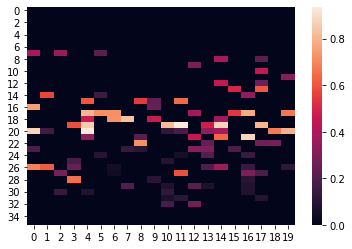

[(19, 11, 0.93442726, tensor(0.9069), tensor([0.0768, 0.9834])),
 (20, 4, 0.9290793, tensor(0.9652), tensor([-0.2264,  0.9837])),
 (21, 16, 0.8781811, tensor(0.8832), tensor([-0.0422,  0.8318])),
 (19, 14, 0.87768215, tensor(0.9086), tensor([ 0.6137, -0.9651])),
 (20, 0, 0.8771199, tensor(0.8763), tensor([0.0853, 0.9590])),
 (19, 4, 0.85456747, tensor(0.9895), tensor([-0.6007,  0.9873])),
 (18, 7, 0.8295627, tensor(0.9900), tensor([-0.3730,  0.9849])),
 (19, 10, 0.81840277, tensor(0.8554), tensor([0.4550, 0.9788])),
 (17, 4, 0.806003, tensor(0.9929), tensor([-0.7146,  0.9787])),
 (19, 17, 0.79991925, tensor(0.8919), tensor([ 0.8788, -0.7814])),
 (20, 19, 0.7927716, tensor(0.9175), tensor([ 0.8538, -0.1703])),
 (17, 16, 0.77798754, tensor(0.9443), tensor([0.7682, 0.9698])),
 (16, 0, 0.7512932, tensor(0.9932), tensor([-0.7685,  0.9628])),
 (18, 6, 0.7246954, tensor(0.8270), tensor([ 0.9726, -0.9849])),
 (22, 8, 0.7187908, tensor(0.8475), tensor([0.7582, 0.9856])),
 (17, 5, 0.71804446, te

In [856]:
_ = sns.heatmap(conductivity); plt.show()
[(l, h, v, k_comp_max[l, h], eigv_positivity[l, h]) for l, h, v in list(zip(*topk_md(conductivity, 20)))]

In [117]:
for l0, h0, l2, h2 in zip(*np.unravel_index(affinities.view(-1).topk(100).indices, affinities.size())):
    if True: #(l0, h0) == (8, 7) and (l2, h2) == (22, 5):
        wv0, wo0 = get_head_weights(model, l0, h0, transpose=True)[2:]
        wq2, wk2 = get_head_weights(model, l2, h2, transpose=True)[:2]
        q, kT = (wv0 @ wo0 @ wv1 @ wo1 @ wq2), wk2.T
        eigv_pos = plot_eigv((kT @ q).eig()[0], plot=False)
        print(f'{l0}-{h0}, {l2}-{h2}', eigv_pos, eigv_positivity[l2, h2])

8-13, 22-5 -0.9546549320220947 tensor([0.2356, 0.9942])
8-13, 13-2 -0.925249457359314 tensor([0.0715, 0.9286])
8-13, 23-2 -0.952625036239624 tensor([0.3257, 0.7724])
8-13, 14-6 -0.9559704661369324 tensor([-0.3117,  0.8779])
8-13, 24-11 -0.9397340416908264 tensor([0.1355, 0.2573])
8-13, 22-9 -0.954197883605957 tensor([0.3672, 0.9473])
8-7, 13-2 0.92552649974823 tensor([0.0715, 0.9286])
8-13, 22-4 -0.9488561749458313 tensor([0.3533, 0.9606])
8-7, 22-5 0.9420260787010193 tensor([0.2356, 0.9942])
8-13, 25-12 -0.9469071626663208 tensor([-0.2789, -0.5519])
8-13, 22-14 -0.9512686729431152 tensor([0.1494, 0.9393])
8-13, 23-15 -0.9494166374206543 tensor([0.2682, 0.9750])
8-7, 22-9 0.9410725831985474 tensor([0.3672, 0.9473])
8-13, 21-13 -0.9573714733123779 tensor([-0.1796,  0.9788])
8-7, 14-6 0.9359185695648193 tensor([-0.3117,  0.8779])
8-13, 21-4 -0.9569198489189148 tensor([0.2638, 0.9203])
8-7, 23-2 0.9398887753486633 tensor([0.3257, 0.7724])
8-7, 24-11 0.925784707069397 tensor([0.1355, 0.257

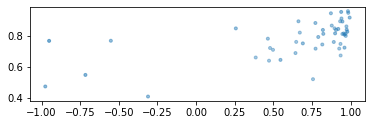

In [259]:
names, affinity_val, eigv_pos_ov, k_comp = zip(*[(f'{l}-{h}', v, eigv_positivity[l, h, 1].item(), k_comp_max[l, h].item()) 
        for l, h, v in zip(*topk_md(na2, 50))])
# plt.figure(figsize=(16, 10))
plt.gca().set_aspect('equal', adjustable='box')
_ = plt.scatter(x=eigv_pos_ov, y=k_comp, marker='.', alpha=affinity_val)

In [ ]:
[(l, h, v, eigv_positivity[l, h]) for l, h, v in zip(*topk_md(k_comp_max, 100))]

## Positional heads & K-compositions

In [ ]:
plt.figure(figsize=(10, 10))
plt.gca().set_aspect('equal', adjustable='box')
_ = plt.scatter(x=eigv_positivity[:, :, 1].view(-1), y=k_comp_max.view(-1), marker='.')#, alpha=affinity_val)

In [343]:
def get_score(attentions, offset=-1, substract_null_attn=True):
    null_attn = attentions[:, :, abs(offset):, 0].clone()  # l n i-1
    if substract_null_attn: null_attn[:, :, 0] = 0
    else: null_attn[:] = 0
    return (attentions.diagonal(offset=offset, dim1=-2, dim2=-1) / (1 - null_attn)).mean(-1)

In [341]:
with torch.no_grad(): attentions = forward(model, torch.randint(100, 25000, size=(1, 125))).attentions
attentions = torch.cat(attentions)  # l*1nij->lnij

In [ ]:
positional_heads = list(zip(*topk_md(get_score(attentions).detach(), k=60)[:]))

In [ ]:
positional_heads = sorted(positional_heads, key=lambda x: x[-1], reverse=True)  # sorted by value
positional_heads = sorted(positional_heads, key=lambda x: x[0]) # then by layer
positional_heads
pos_heads2val = OrderedDict(((l, h), v) for l, h, v in positional_heads)

In [878]:
# 14-1, 15-19, 16-14, 11-4
pos_heads2val[15, 19]

0.99640185

In [ ]:
14-1, *16-14, 15-19/17-5, 20-18, 25-3

In [1000]:
l_1, h_1 = 14, 1; wv_1, wo_1 = get_head_weights(model, l_1, h_1, transpose=True)[2:]
get_eigv_pos(wo_1 @ wv_1), eigv_positivity[l_1, h_1]

(0.9454880952835083, tensor([-0.8995,  0.7189]))

In [995]:
l0, h0 = 17, 5; wq0, wk0, wv0, wo0 = get_head_weights(model, l0, h0, transpose=True)[:]
# l1, h1 = 20, 18; wv1, wo1 = get_head_weights(model, l1, h1, transpose=True)[2:]
# l2, h2 = 25, 3; wq2, wk2 = get_head_weights(model, l2, h2, transpose=True)[:2]

In [967]:
ln_1 = blocks[l_1].ln_1
ln0 = blocks[l0].ln_1
ln1 = blocks[l1].ln_1
ln2 = blocks[l2].ln_1

In [964]:
ln_1 = ln0 = ln1 = ln2 = lambda x: x

In [994]:
get_eigv_pos(wk0.T @ wq0)
eigv_positivity[l0, h0]

0.2718321979045868

tensor([-0.7255,  0.8016])

In [998]:
get_eigv_pos((wv_1 @ wo_1 @ wk0).T @ wq0)

0.9574199318885803

In [968]:
q, k = ln2(ln1(ln0(_e) @ wv0 @ wo0) @ wv1 @ wo1) @ wq2, ln2(_e) @ wk2
get_eigv_pos(k.T @ q)

0.8744850754737854

In [969]:
q, k = ln2(ln1(ln0(ln_1(_e) @ wv_1 @ wo_0) @ wv0 @ wo0) @ wv1 @ wo1) @ wq2, ln2(_e) @ wk2
get_eigv_pos(k.T @ q)

0.8417677283287048

In [ ]:
for l, h, v in sorted(positional_heads, key=lambda x: x[-1], reverse=True):
    wv, wo = get_head_weights(model, l, h, transpose=True)[2:]
    print(f'{l}-{h}', eigv_positivity[l, h], get_eigv_pos(wv @ wo))

14-1 tensor([-0.8995,  0.7189]) 0.9454862475395203
15-19 tensor([-0.8397,  0.7201]) 0.96815425157547
13-10 tensor([-0.9038,  0.8131]) 0.9687303900718689
12-12 tensor([-0.9140,  0.7475]) 0.9646218419075012
10-13 tensor([-0.9199,  0.7544]) 0.939835250377655
9-15 tensor([-0.9113,  0.7524]) 0.9586384892463684
18-18 tensor([-0.5565,  0.9380]) 0.9824914932250977
13-3 tensor([-0.5683,  0.5145]) -0.23620714247226715
16-14 tensor([-0.6133,  0.7393]) 0.9589544534683228
11-4 tensor([-0.7311,  0.7182]) 0.9456425905227661
13-0 tensor([-0.4066,  0.8989]) 0.9820750951766968
11-2 tensor([-0.7251,  0.5582]) 0.6219632625579834
20-9 tensor([-0.4930,  0.9420]) 0.9858207106590271
17-18 tensor([-0.3953,  0.3420]) 0.989426851272583
13-17 tensor([-0.7190, -0.4365]) 0.9877278208732605
7-15 tensor([-0.8882,  0.3095]) -0.7391384243965149
8-7 tensor([-0.8168, -0.1683]) -0.9804646372795105
11-17 tensor([-0.4183,  0.8220]) 0.9584969878196716
16-18 tensor([-0.2862,  0.6096]) 0.9532425999641418
14-2 tensor([-0.6611, 

In [431]:
wvs0, wos0 = zip(*[get_head_weights(model, l, h, transpose=True)[2:] for l, h, _ in positional_heads])
wvs0 = rearrange(list(wvs0), 'b e d -> b e d')
wos0 = rearrange(list(wos0), 'b d e -> b d e')
pos_head_outputs = rearrange([blocks[l].ln_1(_e) for l, _, _ in positional_heads], 'b v e -> b v e')
pos_head_outputs = pos_head_outputs @ wvs0 @ wos0  # bve,bed,bde->bve

In [432]:
k_compositions = torch.zeros(L, H, len(positional_heads))
for l1 in tqdm(range(L)):
    ln_e = blocks[l1].ln_1(_e)
    ln_pos_head_outputs = blocks[l1].ln_1(pos_head_outputs)
    for h1 in range(H):
        if l1 == 0:
            eigv_pos = [-1. for _ in range(len(positional_heads))]
        else:
            wq1, wk1, wv1, wo1 = get_head_weights(model, l1, h1, transpose=True)
            q = ln_e @ wq1
            k = ln_pos_head_outputs @ wk1
            M = k.transpose(-2, -1) @ q   # bdv,vd->bdd
            eigv_pos = [get_eigv_pos(m) for m in M]
            eigv_pos = [ep if l < l1 else 0. for ep, (l, h, v) in zip(eigv_pos, positional_heads)]
        k_compositions[l1, h1] = torch.Tensor(eigv_pos)

100%|██████████| 36/36 [15:45<00:00, 26.27s/it]


In [ ]:
# np.savez_compressed('k_compositions_gpt2-large.npz', k_compositions=np.array(k_compositions), positional_heads=positional_heads)

In [1019]:
k_compositions[k_compositions == -1] = 0

In [1020]:
# d = np.load('k_compositions.npz')
# k_compositions = d['k_compositions']
k_comp_max = k_compositions.max(-1)[0]
k_comp_min = k_compositions.min(-1)[0]
k_comp_mean = k_compositions.abs().mean(-1)

In [1024]:
sorted([(head, k_comp) for head, k_comp in zip(positional_heads, k_compositions[17, 5])],   # 15-4, 17-5
    key=lambda x: x[-1], reverse=True)[:60]

[((12, 12, 0.99433327), tensor(0.9886)),
 ((13, 10, 0.9943394), tensor(0.9884)),
 ((14, 1, 0.9982092), tensor(0.9853)),
 ((5, 13, 0.3133156), tensor(0.9851)),
 ((15, 19, 0.99640185), tensor(0.9823)),
 ((11, 5, 0.4515028), tensor(0.9789)),
 ((6, 2, 0.45406038), tensor(0.9775)),
 ((4, 1, 0.3204057), tensor(0.9768)),
 ((13, 0, 0.6152329), tensor(0.9765)),
 ((8, 12, 0.47088137), tensor(0.9755)),
 ((7, 6, 0.3668253), tensor(0.9751)),
 ((14, 17, 0.4667227), tensor(0.9748)),
 ((10, 13, 0.93084025), tensor(0.9715)),
 ((7, 4, 0.32308346), tensor(0.9712)),
 ((4, 3, 0.33836854), tensor(0.9686)),
 ((5, 14, 0.38716853), tensor(0.9583)),
 ((11, 4, 0.61957556), tensor(0.9576)),
 ((9, 15, 0.841846), tensor(0.9568)),
 ((15, 2, 0.33278787), tensor(0.9546)),
 ((16, 1, 0.41504315), tensor(0.9544)),
 ((11, 17, 0.53026474), tensor(0.9525)),
 ((16, 18, 0.51938623), tensor(0.9517)),
 ((9, 17, 0.44266853), tensor(0.9484)),
 ((6, 16, 0.4213425), tensor(0.9398)),
 ((8, 7, 0.5401789), tensor(0.9355)),
 ((7, 15, 0

## Interpret QK/OV circuits

In [420]:
p = wp.size(1) #// 2  # 1024
_wp = wp[:, :p]
_p = mlp(_wp.T) + _wp.T

In [427]:
layer, head = 13, 10
wq, wk, wv, wo = get_head_weights(model, layer, head, transpose=True)
with torch.no_grad():
    eq = ek = e = blocks[layer].ln_1(_p)
    q, k = eq @ wq, ek @ wk
    m = q @ k.T
m.diagonal(offset=-1).mean()

In [365]:
def T(f): return lambda x: f(x.T).T
mlp = lambda x: mlp_forward(blocks[0], x)
v = we.size(1) #// 2
_we, _wu = we[:, :v], wu[:v]
with torch.no_grad(): _e = mlp(_we.T) + _we.T

In [1092]:
l0, h0 = 16, 2; wv0, wo0 = get_head_weights(model, l0, h0, transpose=False)[2:]
l1, h1 = 19, 11; wv1, wo1 = get_head_weights(model, l1, h1, transpose=False)[2:]
l2, h2 = 27, 17; wq2, wk2 = get_head_weights(model, l2, h2, transpose=False)[:2]

In [1093]:
ln0 = blocks[l0].ln_1; ln1 = blocks[l1].ln_1; ln2 = blocks[l2].ln_1

In [1087]:
ln0 = ln1 = ln2 = lambda x: x

In [1094]:
with torch.no_grad():
    q = wq2 @ T(ln2)(wo1 @ wv1 @ T(ln1)(wo0 @ wv0 @ T(ln0)(_e.T)))
    k = wk2 @ T(ln2)(_e.T)
    _m = q.T @ k

-0.9754061102867126

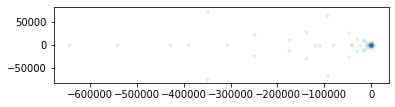

In [1095]:
plot_eigv((k @ q.T).eig()[0])

In [1055]:
# 看head+mlp[0]的ov circuit所作的变换, 2-gram ov 15-3, NE (esp. places) qk 4-4, x->num qk 6-15
# prev ov: 13-9, next num ov: 14-13, next word ov: 13-4, prepend space ov: 18-3/17-10, isa ov: 14-7, antonym ov: 16-14, copy ov 13-2
# NE qk 6-9 who also has copy-like ov
# subword num->whole word num qk and suffix token copy ov 3-6
# 4-3: lower-layer 8-1 12-10 like head
# 10-4: x->adv ov, e.g. including, resulting, subsequently, therefore
# 8-13: place NE qk
# **8-7: coref resolution qk, also very interesting ov
# 6-2: same qk
# 10-7: copy and next fused ov
# 4-1: num, name and place qk
# 24-11: copy ov, esp. num, prepend space
# 22-14: suffix token copy ov
# 21-8: copy ov, 1st letter to upper
# 22-5: copy ov, prepend space, 1st letter to lower, to original form
# 23-2: prefix token copy ov, prepend space, 1st letter to lower
# 3-9: subword->whole word qk for word completion
# 8-2: same qk; 7-9 year and place qk; 7-2 type->instance qk, dual to isa ov 14-7, can be used for coref resolution
# 7-14: x->NE qk; 6-1: x->adv/adj qk; 6-0: x->noun qk; special token and symbol qk 1-7
# next num qk 3-12 (work with prev ov), + 2-11 = same qk!; x->suffix qk 7-6 + 2-11
# prev word+num qk 3-3 (work with next ov), general qk 3-11
layer, head = 15, 5
wq, wk, wv, wo = get_head_weights(model, layer, head, transpose=True)
with torch.no_grad(): eq = ek = e = blocks[layer].ln_1(_e)
# layer0, head0 = 8, 7; wv0, wo0 = get_head_weights(model, layer0, head0, transpose=True)[2:]
# if layer0 is not None: ek = blocks[layer].ln_1(blocks[layer0].ln_1(_e) @ wv0 @ wo0)

with torch.no_grad():
    # A, B = _wu, ln_f(e @ wv @ wo)
    A, B = _wu @ wo.T, e @ wv
    q, k = eq @ wq, ek @ wk

0.6468976736068726

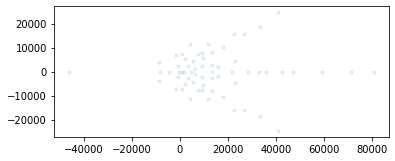

In [1056]:
qk = True
with torch.no_grad():  # ve,ed,de,ev->vv
    # _m = ln(mlp(_we.T)) @ (wq.T @ wk) @ T(ln)(T(mlp)(_we)) if qk else _wu @ T(ln_f)(wo @ (wv @ T(ln)(T(mlp)(_we))))
    _m = q @ k.T if qk else _wu @ ln_f(B @ wo).T
plot_eigv((k.T @ q).eig()[0] if qk else (B.T @ A).eig()[0], start_i=1)

In [1096]:
m = _m  # q->k, output->input
# m = _m.T  # k->q, input->output
values, indices = m.topk(25, largest=True)

In [1097]:
indices_fn = tokenizer.convert_ids_to_tokens
# indices_fn = partial(convert_ids_to_tokens, tokenizer=tokenizer)
# show_topk.indices_fn = tokenizer.convert_ids_to_tokens
show_topk.indices_fn = partial(convert_ids_to_tokens, tokenizer=tokenizer)
for i in values.abs().mean(1).topk(500).indices.tolist():
    print(indices_fn(i), show_topk(values[i][:6].long(), indices[i][:6], indices_fn=indices_fn))

ĠDamian {'fp': 251, 'ĠPacks': 234, 'planes': 230, 'Ġcartridges': 229, 'ĠCSV': 228, 'packs': 219}
ĠNathaniel {'tools': 233, 'fp': 231, 'planes': 230, '710': 223, 'disk': 221, 'Cube': 218}
ĠKil {'Definition': 248, 'Ġdefinition': 233, 'ĠDefinition': 221, 'Attribute': 216, 'ĠDefinitions': 216, 'Ġvirtues': 214}
Ġproof {'Ġbrushes': 223, 'Ġsnaps': 215, 'Ġflipping': 210, 'brush': 208, 'Ġshaking': 206, 'Ġsticks': 205}
ĠBernard {'loads': 220, 'Zip': 210, '800': 209, 'Speed': 206, 'planes': 205, 'Ġphones': 203}
Ġbona {'flash': 221, 'blocking': 216, 'Ġsnaps': 214, 'snap': 209, 'Ġsnapping': 206, 'ĠSnap': 206}
Ġadequately {'ĠShark': 233, 'ĠTroll': 231, 'Ġshark': 224, 'ksh': 216, 'Ġsharks': 213, 'Ġtroll': 208}
Ġgovern {'ksh': 220, 'ĠSlug': 210, '630': 206, '328': 205, 'ggy': 203, '528': 202}
Ġassurances {'26': 219, 'Ġkale': 212, '660': 211, '630': 206, 'Ġ26': 204, '27': 202}
Ġthroughout {'Jack': 231, 'Luke': 219, 'Mike': 217, 'ĠLuke': 207, 'Nick': 201, 'Jason': 199}
ĠPick {'Attribute': 208, 'inity': 

In [162]:
i = tokenizer.encode(' nobody')[0]; print(tokenizer.convert_ids_to_tokens(i))
show_topk(*m[i].topk(10))

Ġnobody


{tensor(47808): 20.703,
 tensor(32451): 20.29,
 tensor(12717): 20.169,
 tensor(41151): 20.052,
 tensor(24990): 19.609,
 tensor(26111): 19.299,
 tensor(24527): 19.258,
 tensor(47021): 18.431,
 tensor(29715): 18.342,
 tensor(28257): 18.078}

## Attribution

In [749]:
def data2str(data):
    i, topk, layer, head, label_type = data.step, data.topk, data.layer, data.head, data.label_type
    # s = f'[{i}] top{topk} {layer}' if head is None else f'[{i}] top{topk} {layer}-{head}'
    s = f'[{i}] top{topk} '
    if head is None: s += f'{layer}'
    elif not isinstance(layer, Iterable): s += f'{layer}-{head}'
    else: s += ','.join([f'{l}-{h}' for l, h in zip(layer, head)])

    if label_type is not None: s = s + ' ' + label_type
    return s

In [750]:
def node2fn(model, node, outputs, labels, attn_attr):
    d = node.data
    i, layer, head, label_type = d.step, d.layer, d.head, d.label_type
    if head is None:
        return partial(mlp_forward, layer=layer) if label_type is None \
            else partial(mlp_forward, layer=layer, labels=labels)
    if label_type == 'attn_labels':
        if isinstance(layer, Iterable): # tuple, list or np.ndarray
            attn_labels = [attn_attr[node.parent.name][l, h] for l, h in zip(layer, head)]
            hidden_states_k = [outputs.hidden_states[l] for l in layer]
        else:
            attn_labels = attn_attr[node.parent.name][layer, head]
            # attn_labels = attn_labels / (attn_labels.sum(-1, keepdim=True) + 1e-9)  # ij->i1 # don't normalize attn attr
            hidden_states_k = outputs.hidden_states[layer]
        kwargs = {'hidden_states_k': hidden_states_k, 'attn_labels': attn_labels}
    else:
        kwargs = {'attn_weights': outputs.attentions[layer]}
        if label_type == 'labels':
            kwargs['labels'] = labels
        elif label_type == 'argmax_labels':
            kwargs['labels'] = get_argmax_labels(model, outputs.head_outputs[layer][:, head], labels)
    return partial(head_forward, layer=layer, head=head, **kwargs)

In [865]:
i = -1
root = Node('[-1] root')
root.data = AttrData(step=i)
nodes = {}
nodes[i] = root
print_tree(root)

 [-1] root


In [868]:
# 查看当前父节点的信息
i
parent = nodes[i]
print(parent.name)
attr = parent.data.attr
list(zip(*topk_md(attr.head, 5)))
list(zip(*topk_md(attr.mlp, 5)))

-1

[-1] root


[(27, 2, 0.38658652),
 (24, 5, 0.2994055),
 (25, 3, 0.25633237),
 (26, 7, 0.2118785),
 (30, 2, 0.16157074)]

[(30, 0.9028856),
 (32, 0.85096246),
 (29, 0.7011418),
 (34, 0.60290617),
 (31, 0.54243064)]

In [869]:
# 选择下一步要归因的head/mlp，创建节点数据
topk = [2, 3]
# layer, head, __ = list(zip(*topk_md(attr.head, 10)))[topk]
layer, head = np.array(list(zip(*topk_md(attr.head, 10)[:2])))[topk].T
# layer, head = list(zip(*topk_md(attr.mlp, 10)))[topk][0], None
label_type = [None, 'labels', 'argmax_labels', 'attn_labels'][-1]
if i == -1: assert label_type in ['labels', 'argmax_labels', 'attn_labels']
else: assert label_type is None
data = AttrData(step=i + 1, topk=topk, layer=layer, head=head, label_type=label_type)
print(data2str(data))

[0] top[2, 3] 25-3,26-7 attn_labels


In [773]:
# 创建节点添加到树，并作为当前父节点
i += 1
node = Node(data2str(data), parent)
node.data = data
nodes[i] = node
print([dt[0] for dt in data_tuples], k_shot)
nodes[i].name = '*' + nodes[i].name
print_tree(root)
nodes[i].name = nodes[i].name[1:]  # strip prepending '*'

['\nfive -> four\nD -> C\neight -> seven\nThursday -> Wednesday\nF -> E\nthree -> two\nc -> b\nJune -> May\nseven -> six\nFebruary -> January\n3 -> 2\nAugust -> July\n', '\nThursday -> Wednesday\nF -> E\nfive -> four\nc -> b\nC -> B\nb -> a\nE -> D\nOctober -> September\nf -> e\nd -> c\n4 -> 3\nApril -> March\n', '\nWednesday -> Tuesday\nFriday -> Thursday\nAugust -> July\nsix -> five\n3 -> 2\nJune -> May\nfour -> three\nC -> B\nSaturday -> Friday\neight -> seven\nThursday -> Wednesday\nApril -> March\n'] 8
 [-1] root┐
          └*[0] top[2, 3] 25-3,26-7 attn_labels


attribute ... done 0:00:01.464357
attribute2 ... done 0:00:04.447765


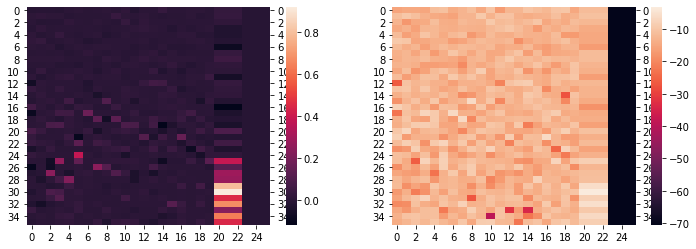

attribute ... done 0:00:01.305659
attribute2 ... done 0:00:05.326980


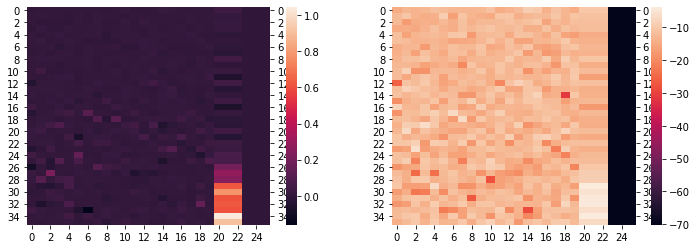

attribute ... done 0:00:01.509654
attribute2 ... done 0:00:04.754685


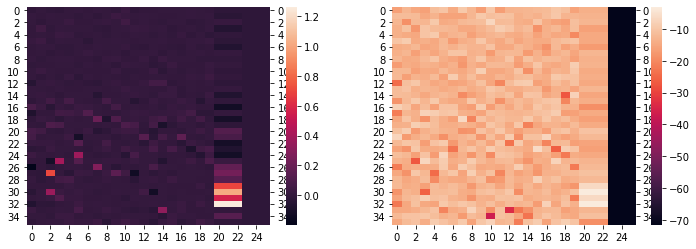

attribution step -1 results


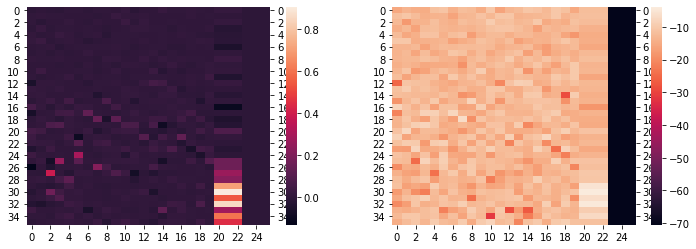

,0,1,2,0,1,2,0,1,0,1
0,27,2,0.386587,18,7,-6.631491,30,0.902886,30,-4.031340
1,24,5,0.299405,21,16,-7.432644,32,0.850962,32,-4.337225
2,25,3,0.256332,20,1,-7.648633,29,0.701142,29,-5.457101
3,26,7,0.211878,17,6,-7.707036,34,0.602906,31,-6.472451
4,30,2,0.161571,23,2,-8.085781,31,0.542431,34,-7.210594
5,18,7,0.140252,16,0,-8.220340,35,0.445327,33,-9.355689
6,17,6,0.130656,19,3,-8.276732,33,0.280759,27,-10.488914
7,21,16,0.128134,25,3,-8.311189,27,0.266822,28,-10.775665
8,33,14,0.119130,35,10,-8.385531,28,0.217688,25,-11.070798
9,28,4,0.116849,15,8,-8.405900,26,0.158853,20,-11.232694


In [866]:
attrs, attrs2 = [], []
for text, examples, inputs, tokens, bos_indices, eos_indices, answers, labels, o, attn_attr in data_tuples[:]:
    fns = []; node = nodes[i]
    while node != root: fns.append(node2fn(model, node, o, labels, attn_attr)); node = node.parent

    (output_layer, _labels) = (nodes[i].data.layer, None) if len(fns) > 0 else (L, labels)
    to_layer = max(output_layer) if isinstance(output_layer, Iterable) else output_layer
    keys = ['attn_weights', 'mlp_mask', 'embed_mask']
    x = OrderedDict((key, get_x(key, o, to_layer=to_layer)) for key in keys)
    fwd_fn = partial(sum_forward, outputs=o, labels=_labels, output_layer=output_layer)
    with Timer('attribute'): attr, ys, logits = attribute(fwd_fn, model, x, fns, num_points=10, batch_size=11)#;  print(ys)

    fwd_fn = partial(sum_forward, outputs=o, labels=_labels, reduce_fn=torch.cat, scaled=False)
    with Timer('attribute2'): attr2 = attribute2(fwd_fn, model, x, fns)

    plot_attr(attr, attr2)
    # pd.concat([to_df(*topk_md(a[: to_layer], 10)) for a in [attr.head, attr2.head, attr.mlp, attr2.mlp]], axis=1)
    attrs.append(attr); attrs2.append(attr2)
    attn_attr[nodes[i].name] = attr.attn # associate non-averageable attn attr to current node in this tricky way
        
print(f'attribution step {i} results')
attr, attr2 = reduce_objects(attrs, ['head', 'mlp']), reduce_objects(attrs2, ['head', 'mlp'])
plot_attr(attr, attr2)
pd.concat([to_df(*topk_md(a[: to_layer], min(to_layer, 10))) for a in [attr.head, attr2.head, attr.mlp, attr2.mlp]], axis=1)
nodes[i].data.attr = attr

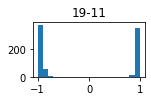

19-11 0.934 K-composition = 0.907 eigenvalue_positivity = tensor([0.0768, 0.9834])


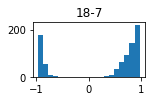

18-7 0.830 K-composition = 0.990 eigenvalue_positivity = tensor([-0.3730,  0.9849])


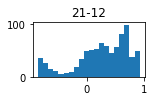

21-12 0.456 K-composition = 0.965 eigenvalue_positivity = tensor([0.1242, 0.9630])


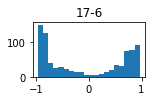

17-6 0.716 K-composition = 0.981 eigenvalue_positivity = tensor([-0.0265,  0.9368])


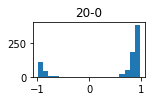

20-0 0.877 K-composition = 0.876 eigenvalue_positivity = tensor([0.0853, 0.9590])
18-18 0.000 K-composition = 0.675 eigenvalue_positivity = tensor([-0.5565,  0.9380])


In [863]:
for l, h, v in zip(*topk_md(attr.head, 5)):
    print('%d-%d %.3f K-composition = %.3f eigenvalue_positivity =' % 
        (l, h, get_conductivity(eigv_positivity012, l, h, plot=True, figsize=(2, 1)),
        k_comp_max[l, h].item()), eigv_positivity[l, h])

27 2 0.38658652 None
tensor([ -9.8955, -10.2993, -18.1159], grad_fn=<CatBackward>)


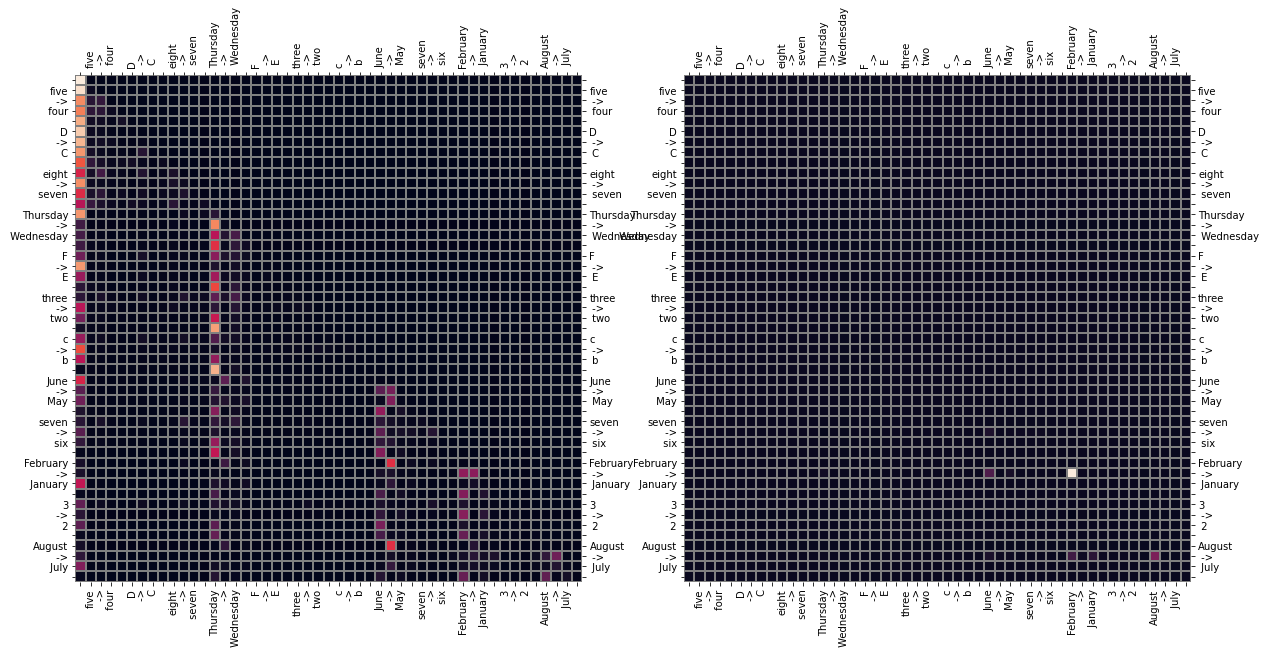

tensor([-10.0132, -14.6102, -26.6496], grad_fn=<CatBackward>)


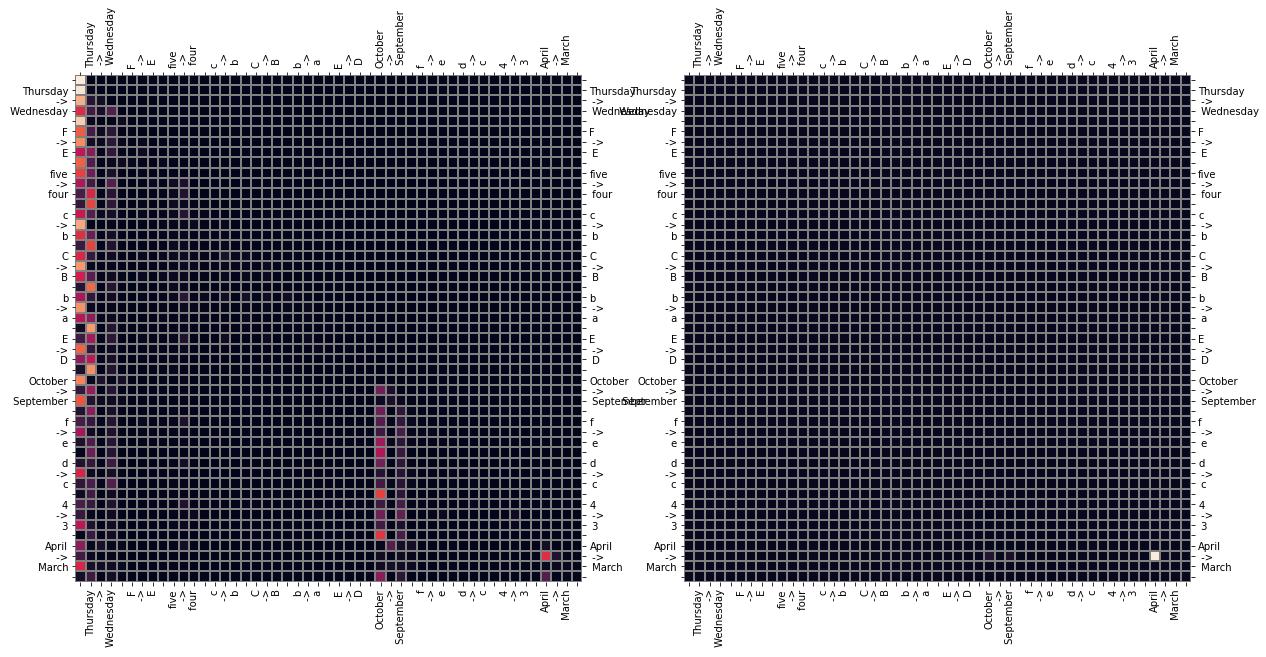

tensor([-10.1852,  -6.5806, -10.4973], grad_fn=<CatBackward>)


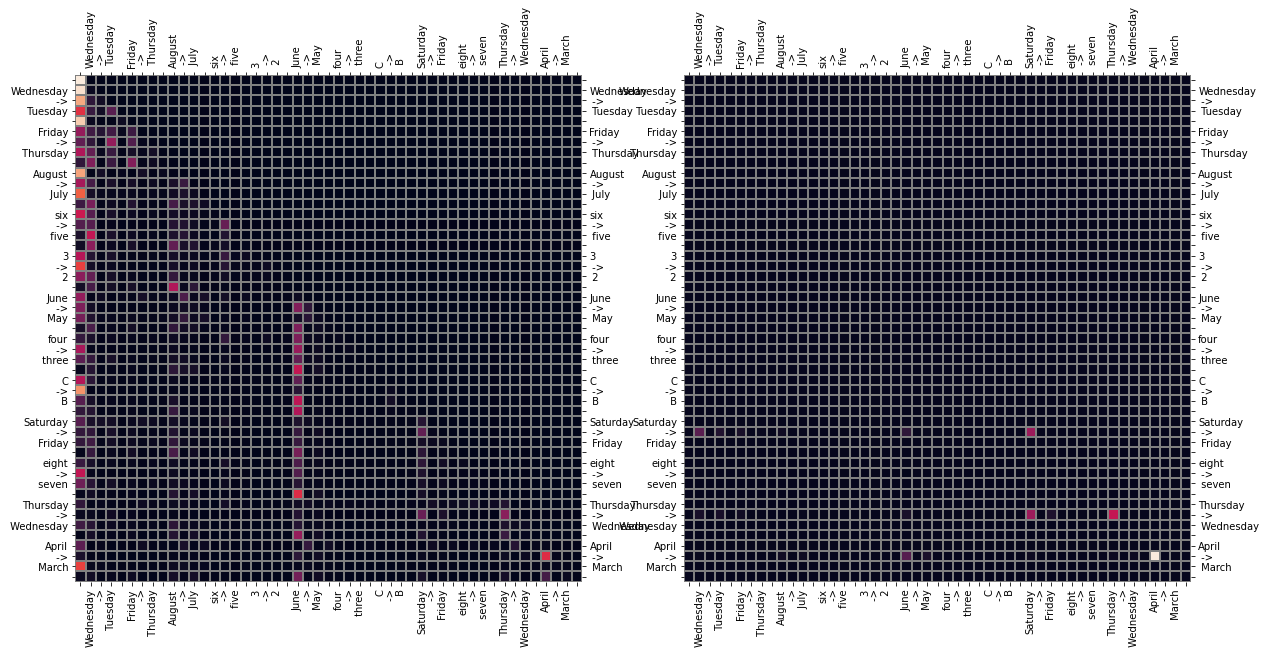

24 5 0.2994055 None
tensor([-10.3062,  -5.5403,  -8.9078], grad_fn=<CatBackward>)


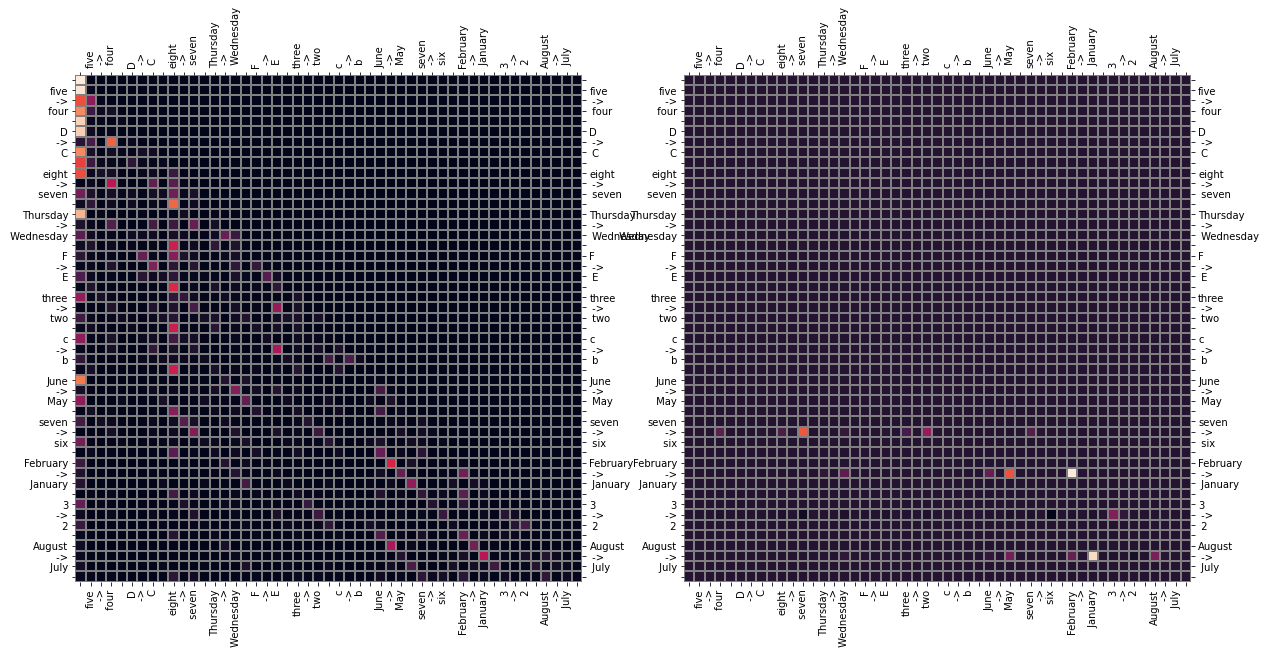

tensor([-10.1091,  -8.5393, -12.3575], grad_fn=<CatBackward>)


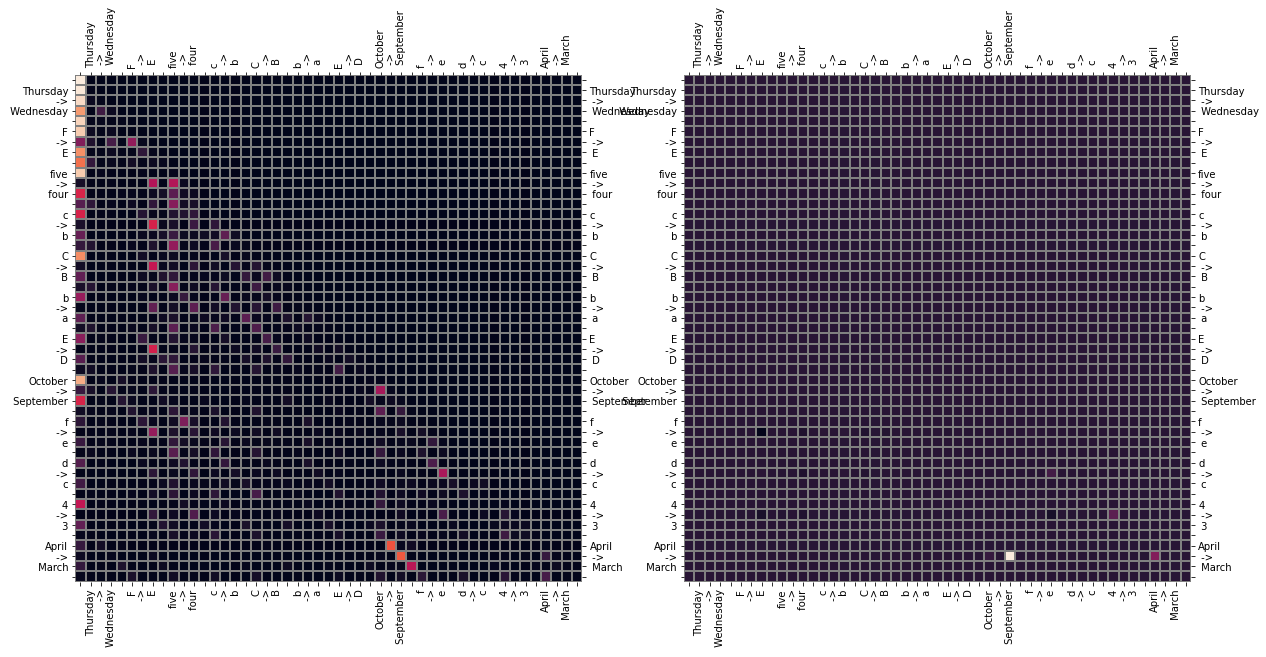

tensor([-10.3822,  -5.3408,  -7.6509], grad_fn=<CatBackward>)


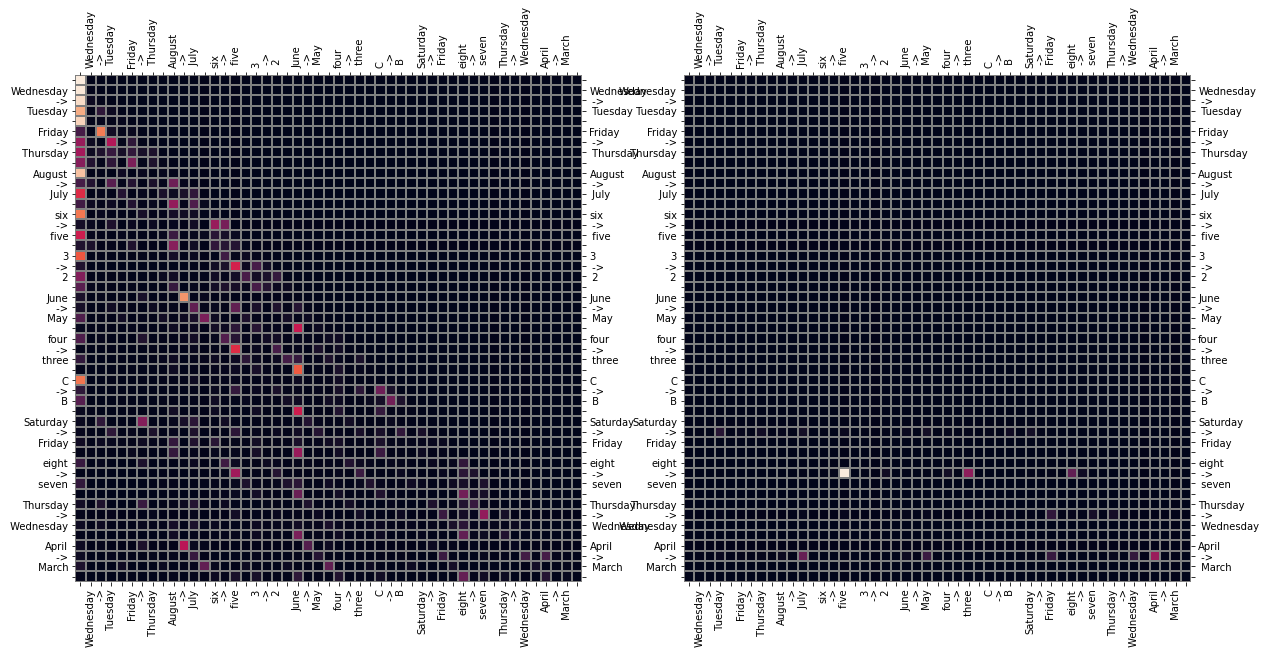

25 3 0.25633237 7
tensor([-9.8679, -6.7648, -7.3030], grad_fn=<CatBackward>)


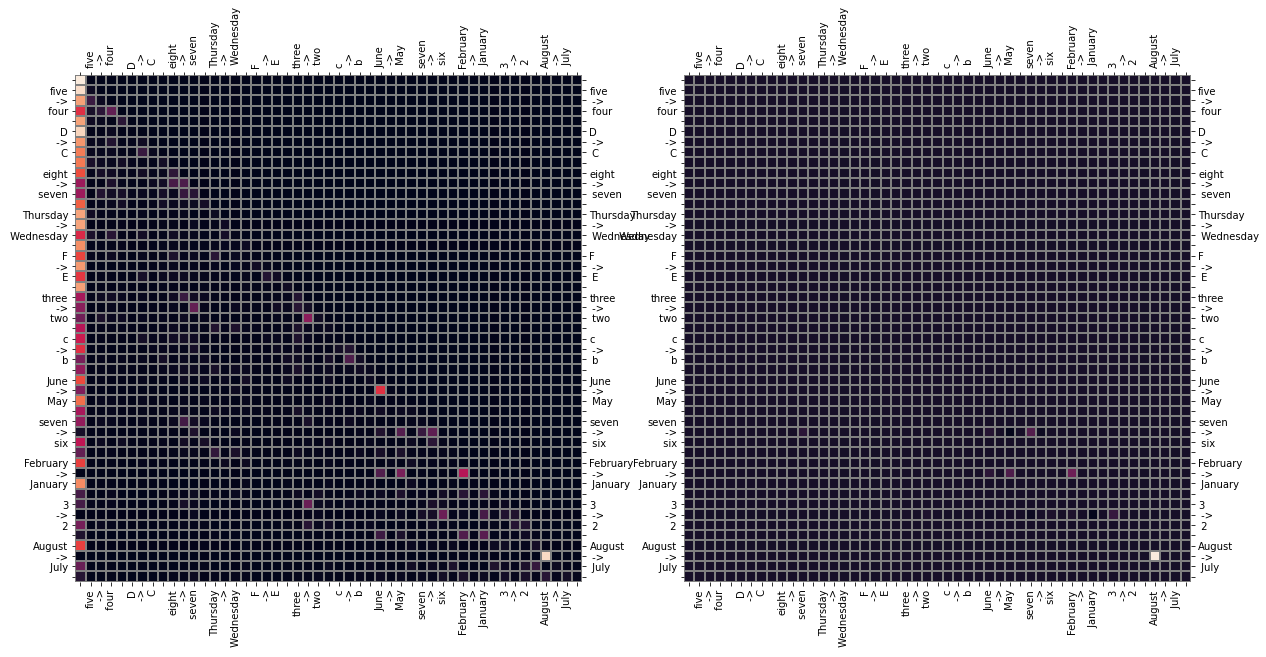

tensor([-10.2183,  -8.7718, -11.2419], grad_fn=<CatBackward>)


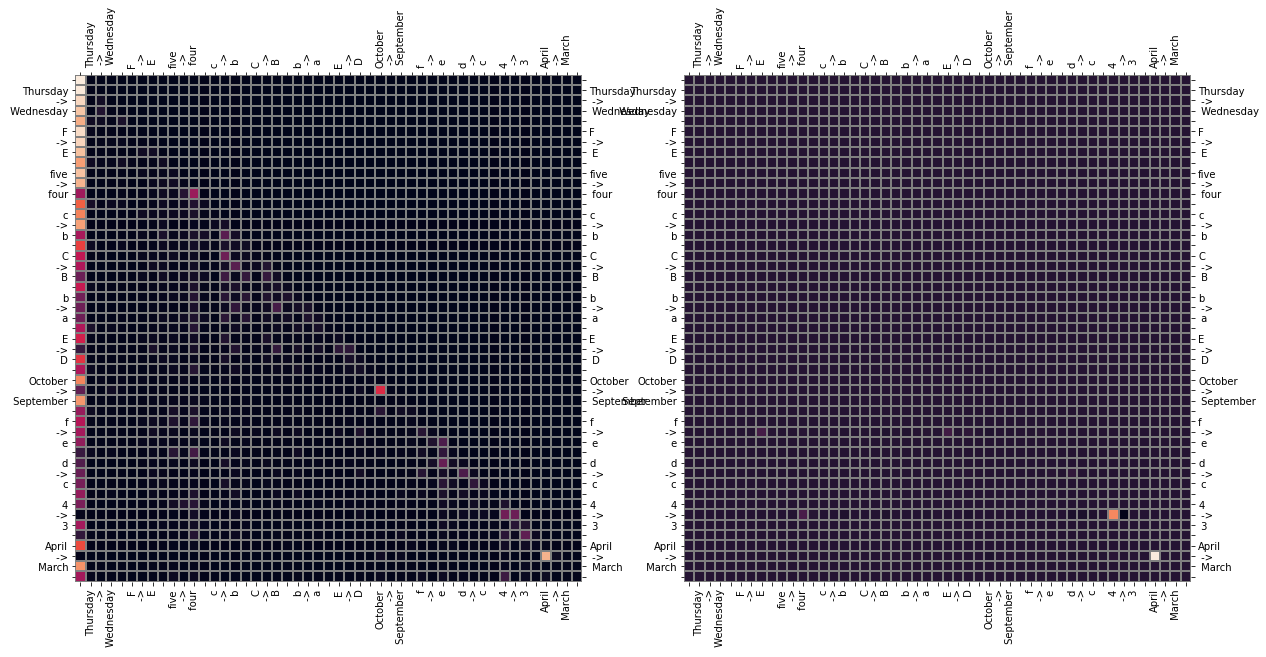

tensor([-10.2867,  -6.7461,  -7.4977], grad_fn=<CatBackward>)


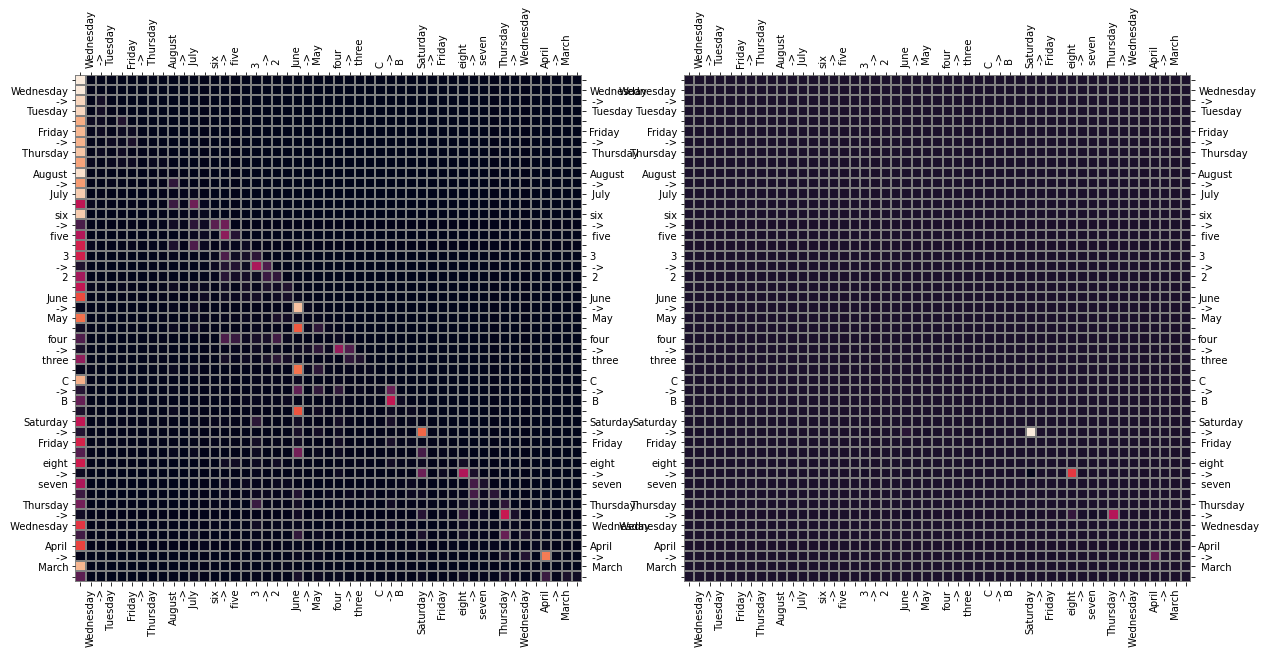

26 7 0.2118785 None
tensor([-10.2420,  -7.1986, -11.3559], grad_fn=<CatBackward>)


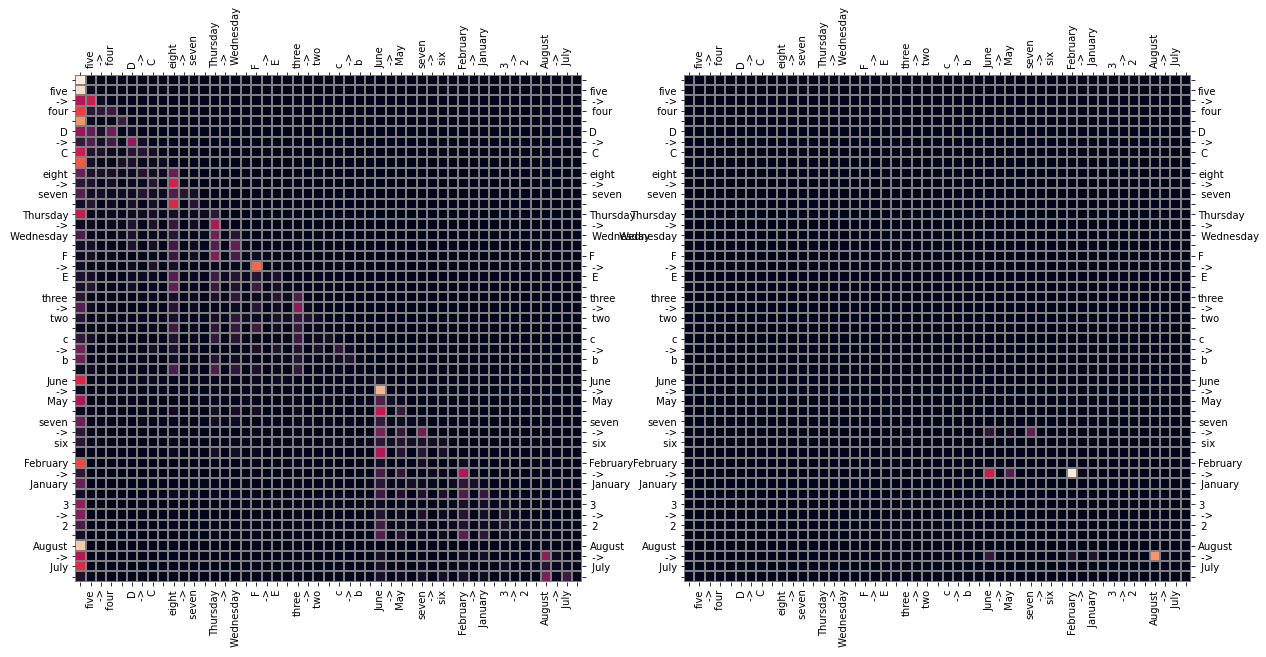

tensor([-10.2724, -10.0104, -15.1613], grad_fn=<CatBackward>)


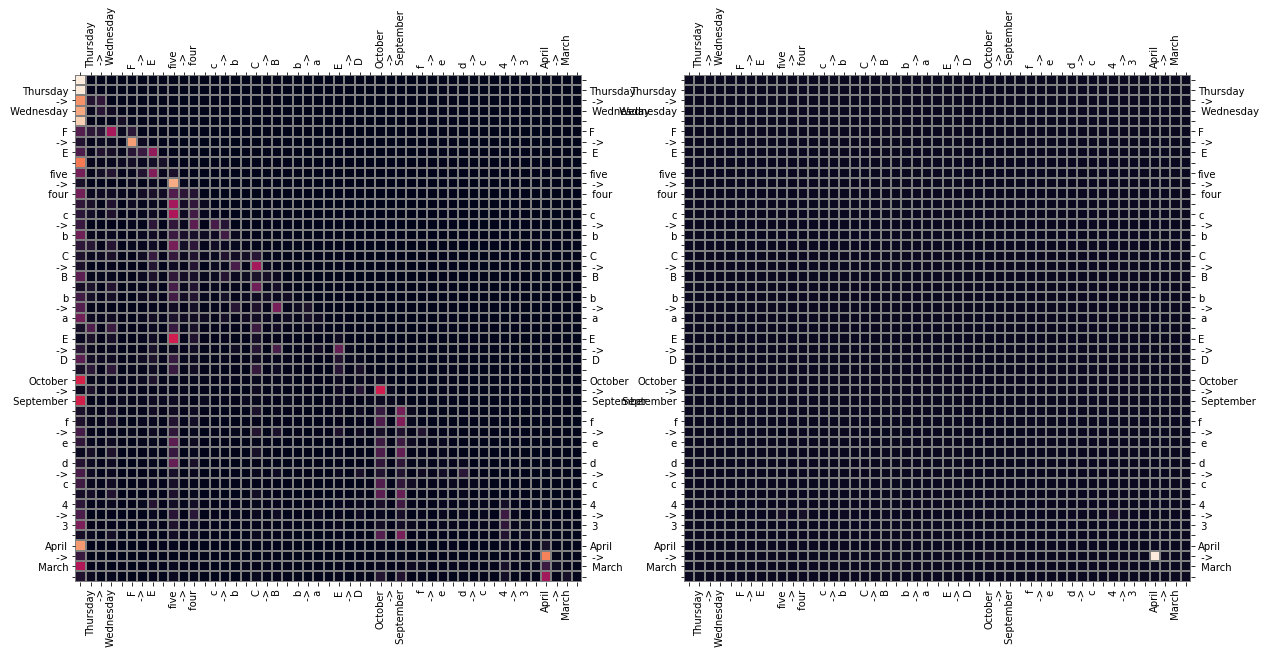

tensor([-10.3553,  -6.1416,  -9.0426], grad_fn=<CatBackward>)


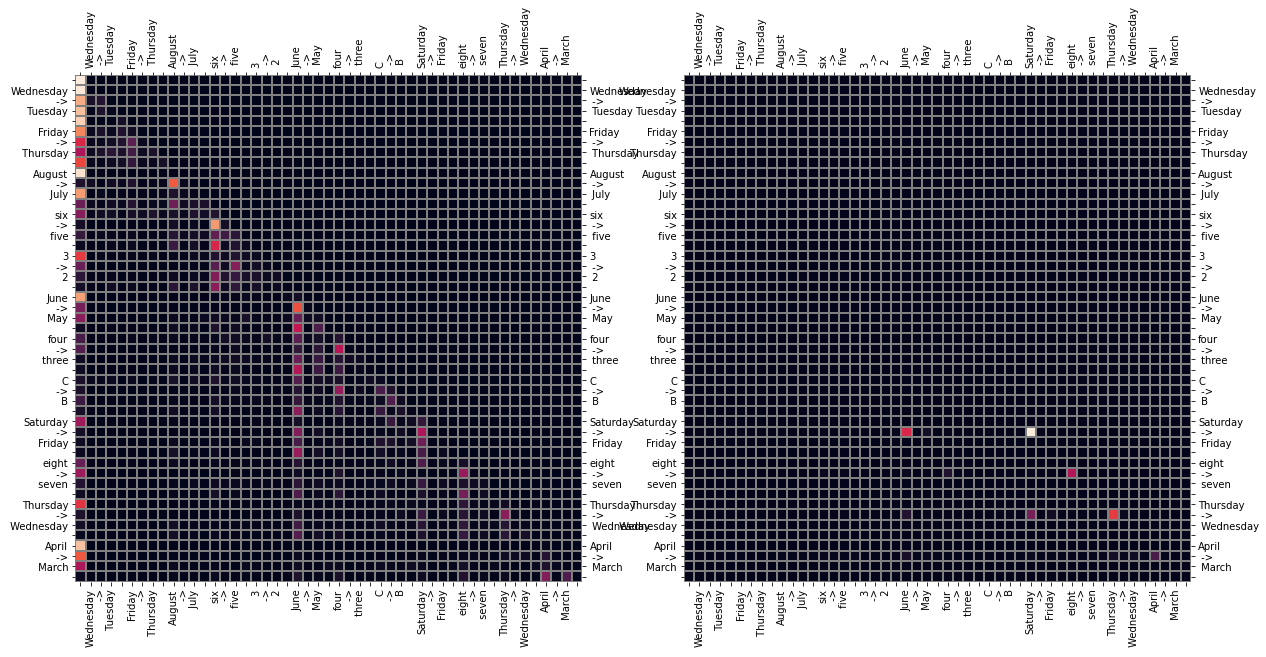

In [867]:
# attr = nodes[i].data.attr
for l, h, v in zip(*topk_md(attr.head, 4)):
    print(l, h, v, get_head_rank(attr2.head, l, h))
    # l = 25
    for text, examples, inputs, tokens, bos_indices, eos_indices, answers, labels, o, attn_attr in data_tuples[:]:
        fns = []; node = nodes[i]
        while node != root: fns.append(node2fn(model, node, o, labels, attn_attr)); node = node.parent
        
        x = OrderedDict((key, get_x(key, o, to_layer=l)) for key in keys)
        fwd_fn = partial(sum_forward, outputs=o)
        fn = partial(head_forward, layer=l, head=h, attn_weights=o.attentions[l],
                            labels=labels if len(fns) == 0 else None)
        # fn = partial(mlp_forward, layer=l, labels=labels)
        post_fwd_fn = compose_forward_fns([fn] + fns, scaled=True)
        _, ys, logits = attribute(fwd_fn, model, x, post_fwd_fn, num_points=3, batch_size=3); print(ys)
        if not isinstance(logits, Iterable) and logits.size(-1) == model.lm_head.out_features:
            _ = show_predictions(text, examples, tokenizer, logits[-1:], bos_indices, eos_indices, answers, labels, 
                topk=4, show_range=range(k_shot, len(examples)), sep='\t')

        fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20, 10))
        aa = attn_attr[nodes[i].name][l, h]
        # attn_labels = aa / (aa.sum(-1, keepdim=True) + 1e-9)  # ij->i1
        for ax, a in zip(axs, [o.attentions[l][0, h], aa, ]):
            plot_attn(a, tokens, ax=ax)
        plt.show()

13 9 1.38291 0
tensor([ -9.0720,  -6.7210, -12.1230], grad_fn=<CatBackward>)
  June 0.0 {'May': 0.966, 'June': 0.029, ' May': 0.005, ' June': 0.0} 	 July -> June
  Thursday 0.05 {'Thursday': 0.95, ' Thursday': 0.05, 'Wednesday': 0.0, ' Wednesday': 0.0} 	 Friday -> Thursday
  J 0.0 {'K': 0.228, 'J': 0.222, 'H': 0.126, 'E': 0.094} 	 K -> J
  second 0.0 {'two': 0.999, 'second': 0.001, ' Two': 0.0, '2': 0.0} 	 third -> second
  September 0.072 {' Sept': 0.323, 'September': 0.144, 'August': 0.084, '09': 0.083} 	 October -> September
  V 0.0 {'G': 0.233, 'J': 0.205, 'H': 0.102, 'M': 0.085} 	 W -> V
  6 0.0 {'6': 0.939, '5': 0.06, '4': 0.002, ' 6': 0.0} 	 7 -> 6
  4 0.0 {'4': 1.0, ' 4': 0.0, '3': 0.0, '5': 0.0} 	 5 -> 4
  seventh 0.0 {'seven': 0.984, 'six': 0.01, '7': 0.002, 'five': 0.001} 	 eighth -> seventh
  1 0.0 {'1': 0.977, '2': 0.023, ' 1': 0.0, '0': 0.0} 	 2 -> 1


(tensor(0.4255, grad_fn=<NllLossBackward>), False)

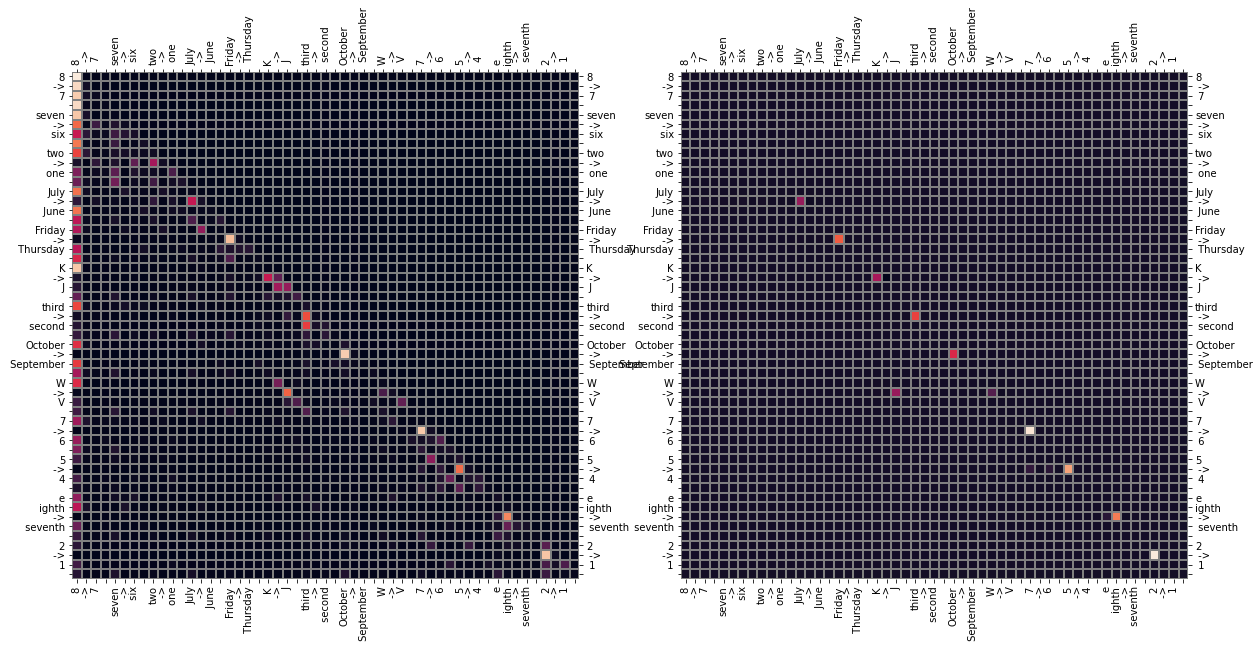

In [268]:
attr = nodes[i].data.attr
for l, h, v in zip(*topk_md(attr.head, 1)):
    # if l != 14: continue
    print(l, h, v, get_head_rank(attr2.head, l, h))
    for text, examples, inputs, tokens, bos_indices, eos_indices, answers, labels, o, attn_attr in data_tuples[1:2]:
        x = OrderedDict((key, get_x(key, o, to_layer=l)) for key in keys)
        fwd_fn = partial(sum_forward, outputs=o)
        fn = partial(head_forward, layer=l, head=h, attn_weights=o.attentions[l],
                            labels=labels if len(fns) == 0 else None)
        post_fwd_fn = compose_forward_fns([fn] + fns, scaled=True)
        _, ys, logits = attribute(fwd_fn, model, x, post_fwd_fn, num_points=3, batch_size=3); print(ys)
        if logits.size(-1) == model.lm_head.out_features:
            show_predictions(text, examples, tokenizer, logits[-1:], bos_indices, eos_indices, answers, labels, 
                topk=4, show_range=range(k_shot, len(examples)), sep='\t')

        fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20, 10))
        aa = attn_attr[nodes[i].name][l, h]
        # attn_labels = aa / (aa.sum(-1, keepdim=True) + 1e-9)  # ij->i1
        for ax, a in zip(axs, [o.attentions[l][0, h], aa, ]):
            plot_attn(a, tokens, ax=ax)
        plt.show()

In [ ]:
# 对某层的attn_weights单独梯度归因
attrs = []
for attribute_layer in range(27):
    forward_fn = partial(forward, inputs=inputs, labels=labels, loss_reduction='per_example_mean', attribute_layer=attribute_layer)
    x = {'head_mask': torch.ones(1, H, o.hidden_states[0].size(1))}
    def get_y(outputs): return -outputs.loss
    attr, ys = attribute(forward_fn, x, get_y, num_points=8)
    ys
    attrs.append(attr)
    
head_attr2 = rearrange([attr['head_mask'] for attr in attrs], 'l n i -> l n i')
head_attr2 = torch.einsum('lni->ln', head_attr2)
list(zip(*topk_md(head_attr2, 10)))

# 对某层的attn_weights单独梯度归因
for attribute_layer, attribute_head, __ in list(zip(*topk_md(head_attr, 10)))[:3]: # heads 27-17, 17-4, 22-13
    forward_fn = partial(forward, inputs=inputs, labels=labels, loss_reduction='per_example_mean', attribute_layer=attribute_layer)
    x = {'attn_weights': o.attentions[attribute_layer]}
    def get_y(outputs): return -outputs.loss
    attr, ys = attribute(forward_fn, x, get_y)
    # ys
    print(attribute_layer, attribute_head)
    plot_attn(attr['attn_weights'][attribute_head], tokens, figsize=(5, 5))
    plt.show()

以上用归因找到对最终预测结果起重要作用的上层heads（induction heads），  
以下用归因找到对上层induction heads的attn_weights起重要作用的下层heads（Q-compostion or K-composition with induction heads）

In [72]:
# 找第2重要的induction head（17-4）的K-composition heads
layer, head, _ = list(zip(*topk_md(head_attr, 10)))[1]
layer, head
aw_label = binarize(attn_attr[layer, head])
wq, wk = get_head_weights(layer, head)[:2]

(17, 4)

In [73]:
# 对head_output归因
query = torch.einsum('bie,de->bid', o.hidden_states[layer], wq)
head_outputs = rearrange(list(o.head_outputs), 'l 1 n i e -> 1 l n i e')[:, :layer]
key = torch.einsum('blnje,de->blnjd', head_outputs, wk)
attn_logits = torch.einsum('bid,blnjd->lnij', query, key) # b==1
# i j l n -> n_label l n -> ln
attn_head_attr = rearrange(attn_logits, 'l n i j -> i j l n')[aw_label == 1].mean(0)

In [ ]:
_ = sns.heatmap(attn_head_attr)
list(zip(*topk_md(attn_head_attr, 10)))

In [80]:
# 对attn_weights归因
# h2: a higher-layer (induction) head (layer, head)
# h1: lower-layer heads forming K-composition with h2
# i: h2 query position, j: h2 key position, k: h1 query position
head_inputs_ = rearrange(list(o.head_inputs), 'l 1 n j e -> l n j e')[:layer]
attentions_ = attentions[:layer]
if True: # faster version
    key = head_inputs_ @ wk.T  # lnje,de->lnjd
    lnkj_attn_logits = torch.einsum('bkd,lnjd->lnkj', query, key) # b==1
    lnkij_attn_logits = torch.einsum('lnij,lnkj->lnkij', attentions_, j_attn_logits)
else: # slower version, but easier to understand (similar to unseal)
    lnije = torch.einsum('lnij,lnje->lnije', attentions_[:layer], head_inputs_)
    key = lnije @ wk.T  # lnije,de->lnijd    
    lnkij_attn_logits = torch.einsum('bkd,lnijd->lnkij', query, key)  # b==1
# kij means k attends i in higher layer, i attends j in lower layer
attn_attn_attr = torch.einsum('lnkij,ki->lnij', lnkij_attn_logits, aw_label)

In [ ]:
for l, h, v in zip(*topk_md(attn_head_attr, 10)):
    print(l, h, v)
    fig, axs = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(15, 5))
    for ax, a in zip(axs, [attentions[l, h], attn_attn_attr[l, h], binarize(attn_attn_attr[l, h])]):
        plot_attn(a, tokens, ax=ax)
    plt.show()

## Tune intermediary heads

In [ ]:
d = defaultdict(int)
pairs = []
for l0, h0, l2, h2 in zip(*np.unravel_index(affinities.view(-1).topk(500).indices, affinities.size())):
    if d[(l0, h0)] < 10:
        d[(l0, h0)] += 1
        pairs.append(((l0, h0), (l2, h2)))
        if len(pairs) == 100: break
Counter([(l0, h0) for (l0, h0), (l2, h2) in pairs]).most_common()
random.shuffle(pairs)
train_set, val_set = pairs[:-20], pairs[-20:]

In [ ]:
def w_forward(head_pairs, wv1, wo1, alpha=0.1, compute_eigv=False):
    wvs0, wos0, wqs2, wks2 = zip(*[get_head_weights(model, l0, h0, transpose=True)[2:] +
                                get_head_weights(model, l2, h2, transpose=True)[:2] 
                                for (l0, h0), (l2, h2) in head_pairs])
    wvs0, wos0 = rearrange(list(wvs0), 'b e d -> b e d'), rearrange(list(wos0), 'b d e -> b d e')
    wqs2, wks2 = rearrange(list(wqs2), 'b e d -> b e d'), rearrange(list(wks2), 'b e d -> b e d')
    wvs0, wos0, wqs2, wks2 = wvs0.to(device), wos0.to(device), wqs2.to(device), wks2.to(device)
    wvo1 = wv1 @ wo1
    q, kT = wvs0 @ wos0 @ wvo1 @ wqs2, wks2.transpose(-2, -1)
    comp_norm = (q @ kT).norm(dim=(-2, -1)).mean()
    # loss = -comp_norm / wvo1.norm()
    loss = -(comp_norm - alpha * wvo1.norm())
    eigvs = [plot_eigv(m.eig()[0], plot=False) for m in kT @ q] if compute_eigv else None
    return loss, comp_norm, eigvs
    
def eval(dataset, wv1, wo1, bsz=8, compute_eigv=False, e=None, wu=None):
    losses, eigvs, comp_norms = [], [], []
    for i in range(len(dataset) // bsz):
        loss, comp_norm, _eigvs = w_forward(dataset[i * bsz: (i + 1) * bsz], wv1, wo1, compute_eigv=compute_eigv)
        losses.append(loss.item())
        comp_norms.append(comp_norm.item())
        if compute_eigv: eigvs += _eigvs
    if compute_eigv:
        print(torch.Tensor(eigvs))
        # e = model.transformer.h[l1].ln_1(_e)
        A, B = wu @ wo1.T.to('cpu'), e @ wv1.to('cpu')
        print('wvo1 eigv_pos =', plot_eigv((B.T @ A).eig()[0], plot=False))
    return round(sum(losses) / len(losses), 4), round(sum(comp_norms) / len(comp_norms), 4), round((wv1 @ wo1).norm().item(), 4)

In [ ]:
device = 'cuda'
wv1, wo1 = get_head_weights(model, l1, h1, transpose=True)[2:]
wv1, wo1 = wv1.detach().clone(), wo1.detach().clone()
wv1, wo1 = wv1.to(device), wo1.to(device)
_ = wv1.requires_grad_(True); _ = wo1.requires_grad_(True)
optimizer = optim.AdamW([wv1, wo1], lr=1e-4)
bsz, eval_bsz = 8, 4
# test(model, data_tuples)
# test(model, data_tuples, replaced_head=(l1, h1), wv=wv1.to('cpu'), wo=wo1.to('cpu'))
# test(model, data_tuples, replaced_head=(l1, h1), wv=wv1.to('cpu'), wo=2*wo1.to('cpu'))
with torch.no_grad(): print('Epoch', -1, 'train', eval(train_set, wv1, wo1), 
                        'val', eval(val_set, wv1, wo1, bsz=eval_bsz, compute_eigv=True, e=e, wu=wu))
for epoch in range(2):
    random.shuffle(train_set)
    for i in tqdm(range(len(train_set) // bsz)):
        optimizer.zero_grad()
        loss = w_forward(train_set[i * bsz: (i + 1) * bsz], wv1, wo1)[0]
        loss.backward()
        optimizer.step()
    with torch.no_grad(): print('Epoch', epoch, 'train', eval(train_set, wv1, wo1), 
                            'val', eval(val_set, wv1, wo1, bsz=eval_bsz, compute_eigv=True, e=e, wu=wu),)
                            # test(model, data_tuples, replaced_head=(l1, h1), wv=wv1.to('cpu'), wo=wo1.to('cpu')))

In [473]:
all_attrs, all_yss = {}, {}

In [324]:
def qk_forward(model, outputs, layer, head, aw_label, attr_x, **mask_kwarges):
    ln = blocks[layer].ln_1
    kwargs = {x: ln(outputs.hidden_states[layer]) for x in ['hq', 'hk', 'hv']}
    kwargs[attr_x] = scaled_ln(ln, sum_forward(model, outputs, **mask_kwarges).hidden_states[0], scale=0.01) # attr_x in ['hq', 'hk']
    aw = attn_forward(blocks[layer], **kwargs)[1][:, head]
    aw_label_sum = torch.einsum('ij->', aw_label)
    # print('aw_label_sum =', aw_label_sum)
    mean_prob = torch.einsum('bij,ij->b', aw, aw_label) / aw_label_sum
    mean_logprob = torch.einsum('bij,ij->b', (aw + 1e-8).log(), aw_label) / aw_label_sum
    print('mean_prob =', mean_prob)
    print('mean_logprob =', mean_logprob)
    return mean_prob, mean_logprob

In [ ]:
# ig attribution
pred_attn = False
keys = ['aw'] #  'attn_out', 'head_out', 'attn_output', 'ffn_output'
keys2 = [] #['head_output', 'attn_output']
layer_range = (0, layer1) if pred_attn else (0, layer_out)
attrs, grads = defaultdict(list), defaultdict(list)
num_points, batch_size = 5, 5
    
for i in tqdm(range(*layer_range)):
    am = get_attn_module(blocks[i])
    scaled_emb, step, grad = {}, {}, {}
    embs = [getattr(o, keys[0])[i]]
    if len(embs) == 1 and keys[0] != 'aw': all_embs[task_name][keys[0]] = embs[0][0]
        
    for key, emb in zip(keys, embs):
        scaled_emb[key], step[key] = scaled_input(emb, num_points)
        _ = scaled_emb[key].requires_grad_(True)
        grad[key] = None
    if i == layer0: ys = []
    for j in range(0, num_points, batch_size):
        sliced_scaled_emb = [scaled_emb[key][j: j + batch_size] for key in keys]
#         for key in keys2: setattr(am if key in ['head_output'] else blocks[i], key, None)
        outputs = forward(am, keys, values=sliced_scaled_emb, exit_module=blocks[layer1+1] if pred_attn else None)
        y = globalize(outputs.attentions[layer2])[:, head2, src, tgt] if pred_attn else outputs.logits.softmax(-1)[:, src, pred_label]
#         h1 = ln1(outputs.hidden_states[12])
#         y = tgt_attn_loss(h1, _attn1, key0, residual=None, temperature=20)
        if i == layer0: ys.append(y)
#         if keys2:
#             sliced_scaled_emb2 = [getdelattr(am if key in ['head_output'] else blocks[i], key) for key in keys2]
#             sliced_scaled_emb += sliced_scaled_emb2
#             if j == num_points - batch_size: step.update({key: emb[-1:]/num_points for key, emb in zip(keys2, sliced_scaled_emb2)})
        sliced_grads = torch.autograd.grad(y.flatten().unbind(), sliced_scaled_emb)
        for gi, key in enumerate(keys + keys2):
            sliced_grad = sliced_grads[gi].sum(dim=0, keepdim=True)
            grad[key] = sliced_grad if key not in grad or grad[key] is None else grad[key] + sliced_grad
    for key in keys + keys2:
        attr = grad[key] * step[key]
        attrs[key].append(attr.data)
        grads[key].append(grad[key].data)

if len(keys) == 1:
    key = keys[0]
    all_attrs[task_name][key + str(int(pred_attn))] = torch.cat([globalize(a) for a in attrs[key]]) \
        if key == 'aw' else attrs[key][0][0]
#     for key in keys2: attrs[key] = torch.cat(attrs[key])

In [ ]:
attrs, yss = all_attrs[key], all_yss[key]

In [ ]:
dlosses = [(ys[0] - ys[-1]).item() for ys in yss]
np.array(dlosses)
_ = plt.bar(range(len(dlosses)), dlosses, 0.3)

In [248]:
# nattrs = [attr / abs(dloss) for attr, dloss in zip(attrs, dlosses)]
nattrs = [attr / attr.abs().mean() for attr in attrs]

In [251]:
mean_nattrs = torch.cat([nattr.mean(dim=-1) for nattr in nattrs])

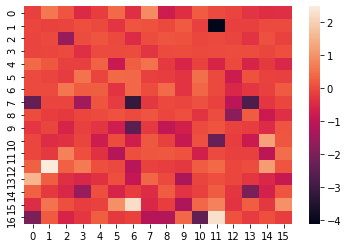

In [252]:
_ = sns.heatmap(mean_nattrs, cbar=True)

In [ ]:
l, h = 6, 6
# attn = o.attentions[l][0, h]
attn = attrs[l][0, h]
plot_attn(attn, tokens)

QK circuit: $W_E^T W_Q^T W_K W_E$  
OV circuit: $W_U W_O W_V W_E$

In [230]:
def plot_eigenvalues(evs, ncols=4):
    fig, axs = plt.subplots(H // ncols, ncols, sharex=True, sharey=True, figsize=(20, 5))
    for i, (e, v) in enumerate(evs):
        e = e.detach().numpy()
        _ = axs[i // ncols][i % ncols].plot(e[:,0], e[:,1], '.')

In [281]:
WQK, WOV = [], []
for l in tqdm(range(L)):
    WQK.append([combine_weights(get_head_weights(l, h), qk=True) for h in range(H)])
    WOV.append([combine_weights(get_head_weights(l, h), qk=False) for h in range(H)])

100%|██████████| 24/24 [00:05<00:00,  4.48it/s]


In [284]:
WQK = [[combine_weights(get_head_weights(l, h), qk=True) for h in range(H)] for l in tqdm(range(L))]
WOV = [[combine_weights(get_head_weights(l, h), qk=False) for h in range(H)] for l in tqdm(range(L))]

100%|██████████| 24/24 [00:01<00:00, 20.26it/s]


In [333]:
# rwqk2, rwov1 = torch.rand(hidden_size, hidden_size) * 10, torch.rand(hidden_size, hidden_size) * 100

# rwq, rwk = torch.rand(hidden_size // H, hidden_size)*10, torch.rand(hidden_size // H, hidden_size)
# rwo, rwv = torch.rand(hidden_size, hidden_size // H), torch.rand(hidden_size // H, hidden_size)*100
# rwqk2, rwov1 = rwq.t().mm(rwk), rwo.mm(rwv)

# rwqk2.mm(rwov1).norm() / (rwqk2.norm() * rwov1.norm())

K-composition: $\text{Id} \otimes A^{h_{-1}} \otimes (W_E^T W_{QK}^h W_{OV}^{h_{-1}} W_E)$, measured by Frobenius norm ratio: $||W_{QK}^{h_2}W_{OV}^{h_1}||_F \mathbin{/} (||W_{QK}^{h_2}||_F ||W_{OV}^{h_1}||_F)$

In [345]:
dl = 3
kcomp3 = np.array([[[(WQK[l][h2].mm(WOV[l-dl][h1]).norm() / (WQK[l][h2].norm() * WOV[l-dl][h1].norm())).item() 
          for h1 in range(H)] for h2 in range(H)] for l in tqdm(range(dl, L))])

100%|██████████| 21/21 [01:23<00:00,  3.96s/it]


In [1703]:
def scatter_plot(a): a = a.detach().numpy(); plt.plot(a[:,0], a[:,1], '.')

In [74]:
chains = [
    [(4, 14), (3, 3)],  # 0.24024388
    [(5, 4), (2, 2)],  # 0.21996385
    [(5, 4), (3, 7)],  # 0.31488344
    [(6, 6), (3, 3)],  # 0.27304175
    [(6, 6), (5, 3)],  # 0.12567882
]

In [314]:
(l2, h2), (l1, h1) = chains[4]

In [433]:
e = WQK[l2][h2].mm(WOV[l1][h1]).eig()[0]

In [435]:
e[:10] = 0

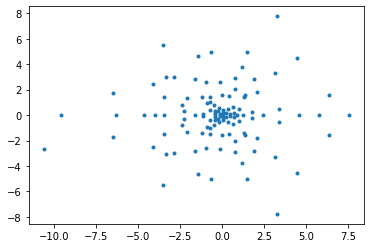

In [436]:
scatter_plot(e)

In [437]:
e = WOV[l2][h2].eig()[0]

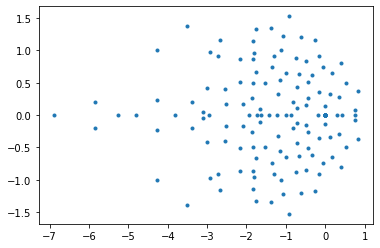

In [438]:
scatter_plot(e)

In [356]:
a = kcomp3[2]; ind = np.unravel_index(a.argmax(), a.shape); ind, a[ind]

((4, 2), 0.21996384859085083)

<AxesSubplot:>

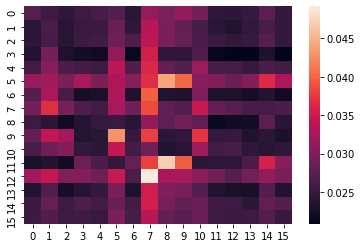

In [319]:
kcomp = np.array(kcomp)
sns.heatmap(kcomp, cbar=True)

In [364]:
wov_evs = [torch.eig(combine_weights(get_head_weights(3, h), qk=False, with_embedding=True, BA=True)) for h in tqdm(range(H))]

100%|██████████| 16/16 [00:02<00:00,  7.17it/s]


  0%|          | 0/16 [3:32:06<?, ?it/s]


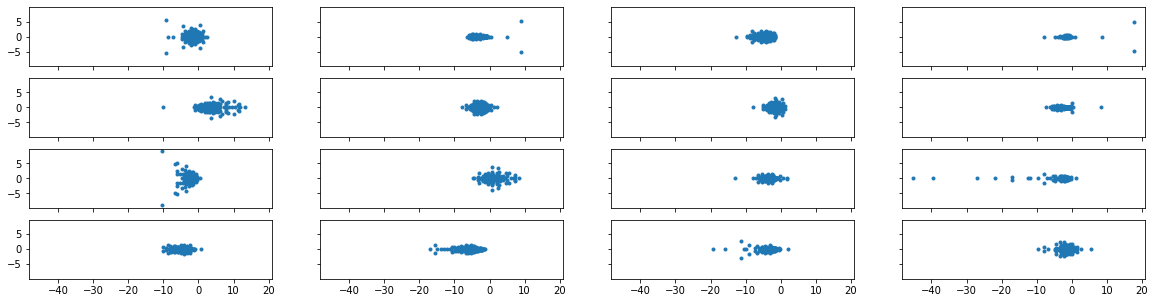

In [363]:
plot_eigenvalues(wov_evs)

In [138]:
w_eu = w_e.matmul(w_u)

In [522]:
def mlp(layer): return lambda x: blocks[layer].mlp(blocks[layer].ln_2(x))
def mlp0(layer): return lambda x: blocks[layer].mlp(x)

In [186]:
def attn(layer): return lambda x: blocks[layer].attn(blocks[layer].ln_1(x))

In [537]:
w_e2 = w_e * 50
w_eu2 = (w_e2 + mlp0(L-1)(w_e2)).matmul(w_u)

In [ ]:
# grad attribution
pred_attn = False
keys = ['aw'] #  'attn_out', 'head_out', 'attn_output', 'ffn_output'
keys2 = [] #['head_output', 'attn_output']
layer_range = (0, layer1) if pred_attn else (0, layer_out)
attrs, grads = defaultdict(list), defaultdict(list)
num_points, batch_size = 5, 5
    
for i in tqdm(range(*layer_range)):
    am = get_attn_module(blocks[i])
    scaled_emb, step, grad = {}, {}, {}
    embs = [getattr(o, keys[0])[i]]
    if len(embs) == 1 and keys[0] != 'aw': all_embs[task_name][keys[0]] = embs[0][0]
        
    for key, emb in zip(keys, embs):
        scaled_emb[key], step[key] = scaled_input(emb, num_points)
        _ = scaled_emb[key].requires_grad_(True)
        grad[key] = None
    if i == layer0: ys = []
    for j in range(0, num_points, batch_size):
        sliced_scaled_emb = [scaled_emb[key][j: j + batch_size] for key in keys]
#         for key in keys2: setattr(am if key in ['head_output'] else blocks[i], key, None)
        outputs = forward(am, keys, values=sliced_scaled_emb, exit_module=blocks[layer1+1] if pred_attn else None)
        y = globalize(outputs.attentions[layer2])[:, head2, src, tgt] if pred_attn else outputs.logits.softmax(-1)[:, src, pred_label]
#         h1 = ln1(outputs.hidden_states[12])
#         y = tgt_attn_loss(h1, _attn1, key0, residual=None, temperature=20)
        if i == layer0: ys.append(y);
#         if keys2:
#             sliced_scaled_emb2 = [getdelattr(am if key in ['head_output'] else blocks[i], key) for key in keys2]
#             sliced_scaled_emb += sliced_scaled_emb2
#             if j == num_points - batch_size: step.update({key: emb[-1:]/num_points for key, emb in zip(keys2, sliced_scaled_emb2)})
        sliced_grads = torch.autograd.grad(y.flatten().unbind(), sliced_scaled_emb)
        for gi, key in enumerate(keys + keys2):
            sliced_grad = sliced_grads[gi].sum(dim=0, keepdim=True)
            grad[key] = sliced_grad if key not in grad or grad[key] is None else grad[key] + sliced_grad
    for key in keys + keys2:
        attr = grad[key] * step[key]
        attrs[key].append(attr.data)
        grads[key].append(grad[key].data)

if len(keys) == 1:
    key = keys[0]
    all_attrs[task_name][key + str(int(pred_attn))] = torch.cat([globalize(a) for a in attrs[key]]) \
        if key == 'aw' else attrs[key][0][0]
#     for key in keys2: attrs[key] = torch.cat(attrs[key])

In [ ]:
plot_attn(globalize(attentions[8])[0, 2], figsize=(20, 20))

In [5395]:
for i, token in enumerate(tokens):
    if token in ['Ċ', '^']: print()
    else: print('%2d %s' %(i, token), end='  ')
tgt_positions


 1 E   2 N   3 K   4 R   5 ->   6 N  
 8 A   9 T  10 D  11 7  12 ->  13 T  
15 Q  16 A  17 P  18 K  19 ->  20 A  
22 A  23 N  24 L  25 5  26 ->  27 N  
29 V  30 1  31 P  32 B  33 ->  34 1  
36 G  37 V  38 7  39 4  40 ->  41 V  
43 R  44 Y  45 J  46 P  47 ->  48 Y  
50 A  51 C  52 S  53 Y  54 ->  55 C  


tensor([ 2,  9, 16, 23, 30, 37, 44, 51])

In [5409]:
a = all_attrs[task_name]['aw' + str(int(pred_attn))]
a = a / a.view(a.size(0), -1).norm(dim=1)[:, None, None, None] #.view(a.size(0), 1, 1, 1)
if not pred_attn:
    src_indices, tgt_indices = [src], [tgt]
    _a = a[:, :, src_indices, tgt_indices]
    values, indices = _a.view(_a.size(0), H, -1).topk(1, dim=-1)
    show_top_heads(values, indices, src_indices=src_indices, tgt_indices=tgt_indices)
    print()
# src_indices = numpy(ans_positions[:])
# src_indices = numpy(tgt_positions + 1)
# tgt_indices = tgt_positions
_a = a[:, :, src_indices, :]
values, indices = _a.view(_a.size(0), H, -1).topk(nrows // 2, dim=-1)
show_top_heads(values, indices, src_indices=src_indices)#, tgt_indices=tgt_indices)

16-15	0.918 [(51, 0.918, 66.8)]	0.13030353 *0.66812056 0.011132528 0.0006797812 
14-0	0.783 [(51, 0.783, 66.5)]	0.14255618 *0.6645065 0.019694159 0.0019851688 
17-13	0.705 [(51, 0.705, 49.8)]	0.18755053 *0.49829417 0.078217894 0.10344336 
13-2	0.505 [(51, 0.505, 44.5)]	0.43078056 *0.44530356 0.017190581 0.001503151 
17-17	0.213 [(51, 0.213, 40.9)]	0.16368316 *0.4086181 0.24944614 0.11208218 
14-13	0.192 [(51, 0.192, 32.8)]	0.20337617 *0.32792574 0.07777147 0.073093265 
15-8	0.159 [(51, 0.159, 22.5)]	0.15539594 *0.22527154 0.26876858 0.27620015 
14-16	0.101 [(51, 0.101, 26.3)]	0.11579089 *0.2628595 0.104256935 0.014017421 
15-16	0.099 [(51, 0.099, 13.2)]	0.13631786 *0.1315605 0.098822616 0.30740336 
13-12	0.095 [(51, 0.095, 13.1)]	0.44031265 *0.13147357 0.035518978 0.05850061 
13-3	0.078 [(51, 0.078, 34.5)]	0.46285912 *0.34470326 0.08684665 0.0354087 
7-2	0.062 [(51, 0.062, 27.9)]	0.105706446 *0.2786354 0.16776893 0.2326701 
17-1	0.047 [(51, 0.047, 46.0)]	0.38024765 *0.45963302 0.023335

In [5408]:
def show_top_heads(values, indices, src_indices=None, tgt_indices=None, topk=15):
    val, ind = values.sum(dim=-1).view(-1).topk(topk)
    val, ind = numpy(val), unravel_index(ind, values.size()[:-1])
    for (l, h), v in zip(ind, val):
        _l = l + layer_range[0]
        if _l <= 3: continue
        top_links = list(zip(unravel_index(indices[l, h], (seq_len, seq_len)), numpy(values[l, h], decimals=3)))
        if src_indices is not None: top_links = [([src_indices[_s], _t], _v) for [_s, _t], _v in top_links]
        if tgt_indices is not None: top_links = [([_s, tgt_indices[_t]], _v) for [_s, _t], _v in top_links]
        top_links = [([_s, _t], _v, numpy(globalize(attentions[_l]) * 100, decimals=1)[0, h, _s, _t]) for [_s, _t], _v in top_links]
        _top_links = [([_s, _t], _v, _a) if len(src_indices) > 1 else (_t, _v, _a) for [_s, _t], _v, _a in top_links]
        print('%d-%d\t%.3f' % (_l, h, v), _top_links, end='\t') 
        if len(top_links) == 1:
            probs = numpy(globalize(attentions[_l])[0, h, src])
            for i in cand_range:
                if i == tgt: print('*', end='')
                print(probs[i], end=' ')
        print()

tensor([0.6156])


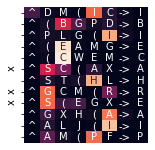

In [5057]:
a = globalize(attentions[layer2])[:, head2]
# a = a.softmax(-1)
a = torch.cat([a[:, i - 1: i, i - ncols - 2: i + 1] for i in ans_positions], dim=1)
# a = a.softmax(-1)
loss = a.view(a.size(0), -1)[:, tgt_positions[1:]].mean(dim=1)
print(loss)
plot_tgt_attn(a[0])

In [3455]:
wvos = [torch.matmul(*get_head_weights(l, h)[2:]) for l, h in [(11, 8), (12, 18)]]
wqk = torch.matmul(*get_head_weights(13, 2)[:2])
ww = wvos[0].matmul(wvos[1]).matmul(wqk)

In [3735]:
ww.norm(dim=0).topk(40).indices

tensor([2484,   88,  578, 1781,  586,  408, 2054,  304,  824, 1675, 1772,  501,
        2456, 1019,  936, 2463, 2368,  340, 2418,  101, 1734,  687, 2159, 1060,
          20, 1838,  224, 1669, 1187,  870, 1585,  232,  281, 1474, 1729,  328,
        1860, 1174,  816, 1524])

In [3741]:
show_topk(*aw.view(-1).topk(20, largest=False), indices_fn=indices_fn)

{(578, 586): -0.0016085216,
 (578, 88): -0.0011706072,
 (936, 1782): -0.0011014504,
 (578, 501): -0.0009034774,
 (578, 114): -0.00086396607,
 (578, 1761): -0.00080681103,
 (578, 1067): -0.0007989705,
 (936, 814): -0.00079893926,
 (936, 405): -0.00076955673,
 (936, 336): -0.0007586547,
 (578, 2149): -0.00074234203,
 (578, 1666): -0.0007264766,
 (578, 408): -0.00071433355,
 (578, 1019): -0.00066249806,
 (936, 946): -0.00065255526,
 (2484, 1675): -0.00064498984,
 (578, 1675): -0.0006330121,
 (578, 1651): -0.00062471436,
 (936, 1445): -0.00062095723,
 (578, 289): -0.0006184878}

In [4065]:
wvos2 = [torch.matmul(*get_head_weights(l, h)[2:]) for l, h in [(9, 9), (10, 1), (12, 18)]]
ww2 = reduce(torch.matmul, wvos2 + [wqk])

In [5015]:
attn_output1, out = None, None
out_proj_w = self1.out_proj.weight.view(hidden_size, H, -1).permute(1, 2, 0).unsqueeze(0)
head_mask = torch.zeros(H, seq_len, seq_len)
head_mask[[18,]] = 1
# head_mask[:] = 1
attn1 = attentions[layer1]
_attn1, __attn1 = torch.zeros_like(attn1), torch.zeros_like(attn1)
for i in range(0, nrows):
    _attn1[:, :, arrow_positions[i], ans_positions[i]] = 1
    __attn1[:, :, arrow_positions[i], ans_positions[:i]] = 1 / i if i > 0 else 0
    
def ffn(layer, x): return blocks[layer].mlp(blocks[layer].ln_2(x))

def tgt_attn_loss(h1, attn1, key0, residual=None, attn_output_w=1, apply_softmax=True, temperature=10, 
                  positions=tgt_positions, plot=False, ax=None):
    def get_attn(attn_output):
        out = (residual if residual is not None else 0) + attn_output * attn_output_w
        if residual is not None: out = out + ffn(layer1, out)
        if residual is not None: out = ln2(out)
        query = out.matmul(wq2.t()).unsqueeze(2) # (bsz, nrows, d_head) -> (bsz, nrows, 1, d_head), ln2 is omissible
        key = key0.matmul(wk2.t()).view(bsz, nrows, ncols + 3, hidden_size // H)
        a = (query * key).sum(-1) # (bsz, nrows, ncols + 3)
        a[:, :, [-1]] = -1e9
        if apply_softmax: a = (a / temperature).softmax(-1)
        return a

    self1.w = attn1 * head_mask; attn_output1 = self1(h1)[0] - self1.out_proj.bias
    a = get_attn(attn_output1[:, arrow_positions])
    loss = a.view(a.size(0), -1)[:, positions]
    if plot:
#         a = a - a.min(dim=2, keepdim=True).values
        plot_tgt_attn(a[0], ax=ax)#; print(loss)
    return loss.mean()

residual = None or hidden_states[layer1][:, arrow_positions]

[0.7721180319786072, 0.9933991432189941, 0.9961371421813965]

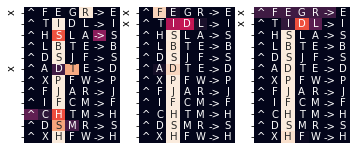

In [5052]:
def get_ln(layer): return blocks[layer].ln_1
# 10-ffn, 9-11 for find special, 9-11 for AbCD->B/b, 9-11 for ABCD->C
# 10-19+ffn+8!, 9-11 for after bracket 5-5/7, 9-11, 10-1+13+ffn+8+19 for in brackets
mask = torch.zeros(H, seq_len, 1); mask[11] = 1#; mask[:] = 0 # 11-8, 10-1, 9-11,   9-11/6?->8-17 for 2nd
# for i in range(0, nrows): mask[1, ans_positions[i], tgt_positions[i]+1] = 1
layer0 = 9
self0, ln0 = get_attn_module(blocks[layer0]), blocks[layer0].ln_1

h0 = hidden_states[9]*0 + head_outputs[8][:, [17]].sum(1)*1
self0.w = attentions[layer0] * mask; attn_output0 = self0((h0), attention_masks[layer0])[0] - self0.out_proj.bias
# h1 = hidden_states[9]*0 + head_outputs[11][:, [8]].sum(1)*1 #+ ffn_outputs[10]#+ head_outputs[11][:, [8,]].sum(1)*1
# h1 = ln1(h1)
h1 = attn_output0
key0 = get_ln(10)(hidden_states[10])#; key0.reqires_grad = True; key0.retain_grad()
fig, axes = plt.subplots(1, 3, sharey=False, figsize=(2.5 * (ncols + 3) / 9 * 3, 5 * nrows / 24))
# loss = tgt_attn_loss(h1, __attn1, key0, residual=None, plot=True, apply_softmax=True, temperature=1, ax=axes[0]); loss
# print('after', key0[:, :, 0])
[tgt_attn_loss(h1, attn, key0, residual=None,plot=True,temperature=1, positions=tgt_positions[(i>0)*2:],ax=ax).item() 
    for i, (attn, ax) in enumerate(zip([_attn1, attn1, __attn1], axes))]
# if losses[0] > 0.8 and losses[-1] > 0.8: print(layer, head, losses)

In [5075]:
def get_weight_norm(w):
    return w.abs().mean().item()

In [5083]:
wvo1 = get_combined_w(9, 11) * get_combined_w(12, 18)
for layer in [8, ]:
    for head in range(H):
        wvo = get_combined_w(layer, head)
        print('%d-%d %.4f %.4f' % (layer, head, get_weight_norm(wvo.matmul(wvo1)) / get_weight_norm(wvo), get_weight_norm(wvo.matmul(wvo1))))

8-0 0.0865 0.0030
8-1 0.0865 0.0016
8-2 0.0866 0.0026
8-3 0.0870 0.0027
8-4 0.0867 0.0019
8-5 0.0873 0.0022
8-6 0.0874 0.0027
8-7 0.0867 0.0023
8-8 0.0867 0.0021
8-9 0.0879 0.0026
8-10 0.0874 0.0023
8-11 0.0866 0.0024
8-12 0.0870 0.0024
8-13 0.0868 0.0023
8-14 0.0866 0.0017
8-15 0.0870 0.0023
8-16 0.0874 0.0029
8-17 0.0865 0.0014
8-18 0.0876 0.0025
8-19 0.0866 0.0024


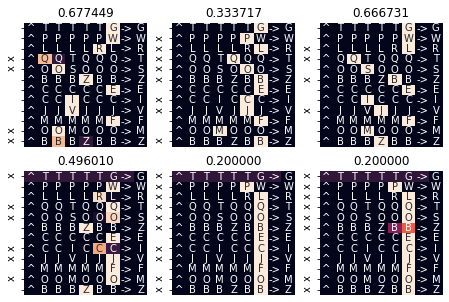

In [4950]:
front_chains = [
    [[(11, 8), create_mask(ans_positions, tgt_positions)]],
    [[(9, 9), create_mask(tgt_positions + 1, tgt_positions)], [(10, 1), create_mask(ans_positions, tgt_positions + 1)]],
]
rear_chains = [
    [[(12, 18), create_mask(arrow_positions, ans_positions)], [(13, 2), None]],
    [[(12, 18), create_mask(arrow_positions, ans_positions, accum=True)], [(13, 2), None]],
]

sum_a = {i: 0 for i in range(len(rear_chains))}
fig, axes = plt.subplots(2, 3, sharey=False, figsize=(2.5 * (ncols + 3) / 9 * 3, 5 * nrows / 24 * 2))
for j, front_chain in enumerate(front_chains):
    l0 = front_chain[0][0][0]
    h = h0 = get_ln(l0)(hidden_states[l0])
    for (layer, head), mask in front_chain:
#         attn = globalize(attentions[layer])[:, head] #if layer in [9] else mask
        attn = mask
        wvo = get_combined_w(layer, head)
        h = attn.matmul(h.matmul(wvo))
    for i, rear_chain in enumerate(rear_chains):
        (layer, head), mask = rear_chain[0]
        attn = mask
        wvo = get_combined_w(layer, head)
        q = attn.matmul(h.matmul(wvo))
        wqk = get_combined_w(*rear_chain[-1][0], qk=True)
        q = q.matmul(wqk)[:, arrow_positions].unsqueeze(2)
        k = h0.view(h0.size(0), nrows, ncols + 3, hidden_size)
        a = q.matmul(k.transpose(-1, -2)).squeeze(2) / 1
        a[:, :, [-1]] = -1e9
        sum_a[i] = sum_a[i] + a
        a = a.softmax(-1)
        loss = a.view(a.size(0), -1)[:, tgt_positions[i*2:]].mean()#; print('%.3f' % loss.item(), end=' ')
        plot_tgt_attn(a[0], ax=axes[i, j], title='%f' % loss.item())

for i in range(len(rear_chains)):
    a = sum_a[i]
    a = a.softmax(-1)
    loss = a.view(a.size(0), -1)[:, tgt_positions[i*2:]].mean()#; print('%.3f' % loss.item(), end=' ')
    plot_tgt_attn(a[0], ax=axes[i, 2], title='%f' % loss.item())

In [4602]:
_sattn, __sattn = torch.zeros(1, seq_len, seq_len), torch.zeros(1, seq_len, seq_len)
for i in range(0, nrows):
    _sattn[:, arrow_positions[i], tgt_positions[i]] = 1
    __sattn[:, arrow_positions[i], tgt_positions[:i]] = 1 / i if i > 0 else 0

0.157 0.497 0.250 
0.100 0.809 0.264 


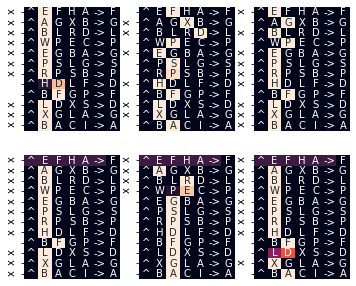

In [4605]:
ww0 = torch.eye(hidden_size)
# layer = 9; ln = blocks[layer].ln_1
# h0 = key0 = ln(hidden_states[layer])
fig, axes = plt.subplots(2, 3, sharey=False, figsize=(2.5 * (ncols + 3) / 9 * 3, 5 * nrows / 24 * 2))
for i, attn in enumerate([_sattn, __sattn]):
    sum_a = 0
    for j, (w, layer) in enumerate([(ww, 11), (ww2, 9)]):
        ln = blocks[layer].ln_1
        h0 = key0 = ln(hidden_states[layer])
        query = attn.matmul(h0)[:, arrow_positions].matmul(w).unsqueeze(2)
        key = key0.view(key0.size(0), nrows, ncols + 3, hidden_size)
        a = (query * key).sum(-1) / 1
        a[:, :, [-1]] = -1e9
        sum_a = sum_a + a
        a = a.softmax(-1)
        loss = a.view(a.size(0), -1)[:, tgt_positions[i*2:]].mean(); print('%.3f' % loss.item(), end=' ')
        plot_tgt_attn(a[0], ax=axes[i, j])
    a = sum_a.softmax(-1)
    loss = a.view(a.size(0), -1)[:, tgt_positions[i*2:]].mean(); print('%.3f' % loss.item(), end=' ')
    plot_tgt_attn(a[0], ax=axes[i, 2])
    print()

In [3719]:
aw = ww * ww.grad

In [3721]:
aw.norm(dim=0).topk(10)

torch.return_types.topk(
values=tensor([0.0037, 0.0029, 0.0027, 0.0025, 0.0023, 0.0023, 0.0018, 0.0016, 0.0016,
        0.0016], grad_fn=<TopkBackward>),
indices=tensor([  88,  586, 2484,  408, 1782,  578, 1781, 1019,  405, 1761]))

In [4962]:
head_outputs[9][0, :, ans_positions].norm(dim=-1).mean(-1).topk(10)

torch.return_types.topk(
values=tensor([12.2424, 11.6219, 11.3335, 10.7489,  9.3170,  9.2139,  8.5213,  7.5385,
         6.7957,  6.3538]),
indices=tensor([ 9, 19, 11,  7, 14,  6,  4, 10,  0,  8]))

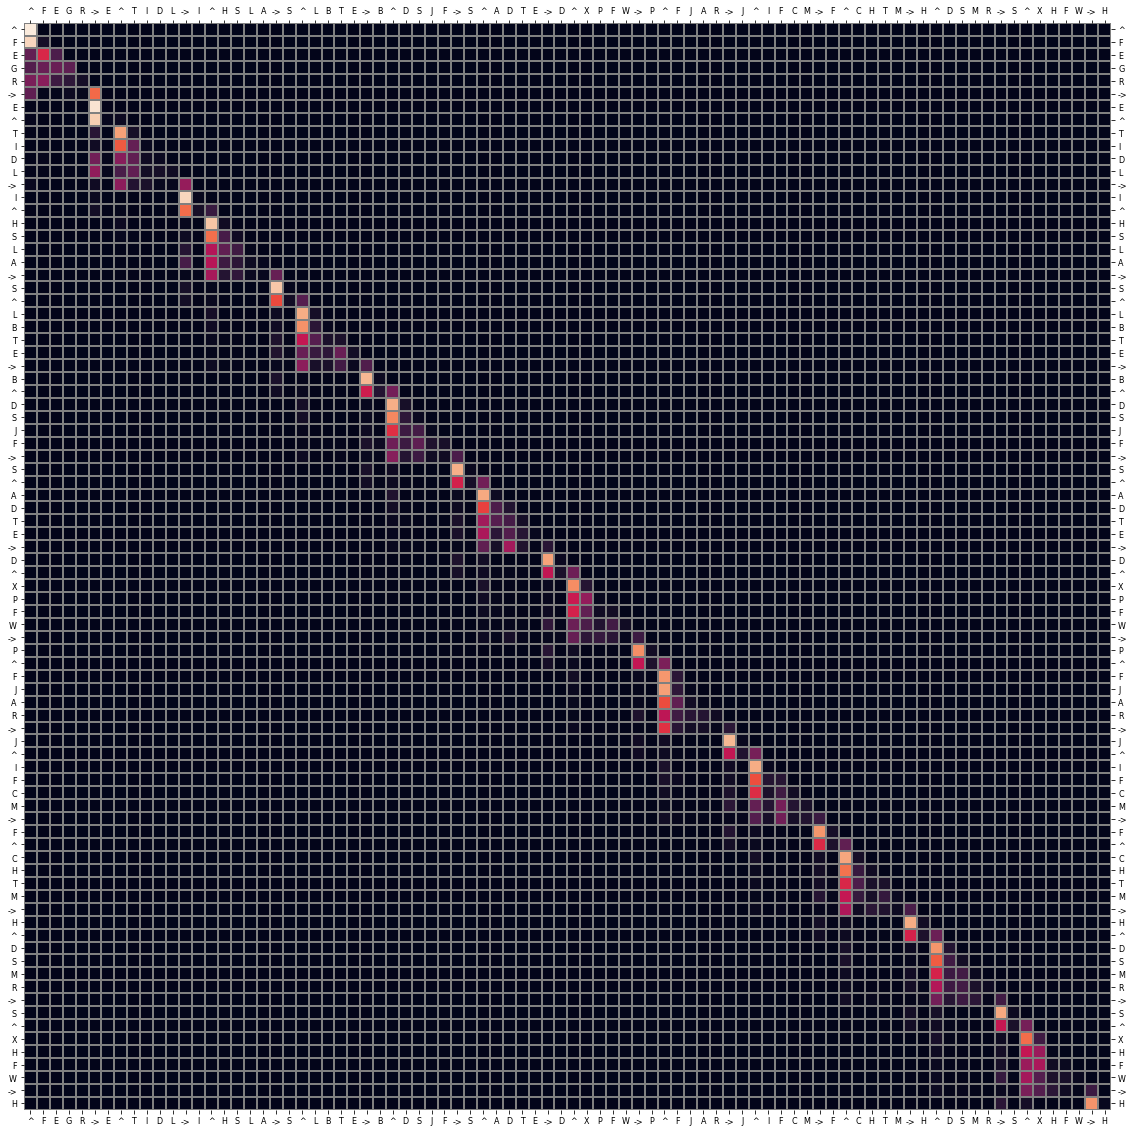

In [5037]:
plot_attn(globalize(attentions[9])[0, 6], figsize=(20, 20))

In [3360]:
a0 = head_outputs[9][0, 11, ans_positions]
a1 = head_outputs[11][0, 8, ans_positions]

In [3362]:
a0 = attrs['head_output'][9, 11, ans_positions]
a1 = attrs['head_output'][11, 8, ans_positions]

In [3363]:
cos = nn.CosineSimilarity(dim=1)
cos(a0, a1)

tensor([0.0226, 0.1145, 0.0712, 0.1595, 0.0533, 0.0150, 0.1125, 0.1410, 0.0172,
        0.0142, 0.0040, 0.0719])

In [3336]:
attr = attrs['attn_output'].sum(-1)
attr = attr / attr.view(attr.size(0), -1).norm(dim=1)[:, None]

<AxesSubplot:>

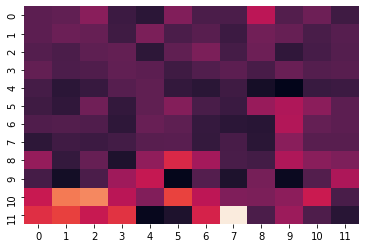

In [3337]:
sns.heatmap(numpy(attr[:, ans_positions]), cbar=False)

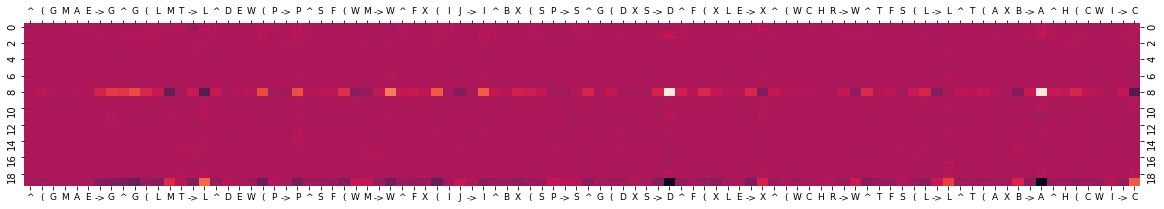

In [3887]:
_ = plt.figure(figsize=(20, 3))
ax = sns.heatmap(numpy(attrs['head_output'].sum(-1)[10]), cbar=False, xticklabels=tokens)
_ = ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=9, rotation=0)
ax.tick_params(top=True, right=True, labeltop=True, labelright=True)

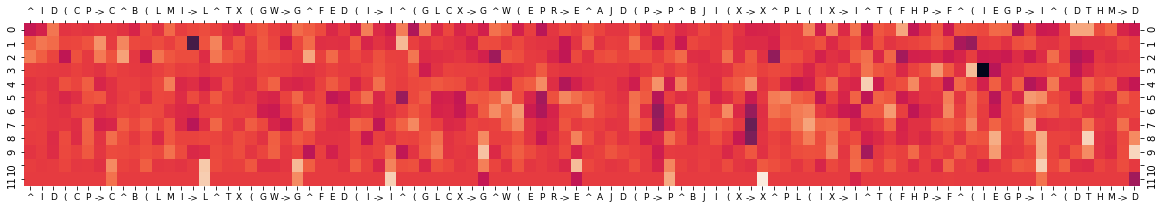

In [3303]:
_ = plt.figure(figsize=(20, 3))
ax = sns.heatmap(numpy(attr), cbar=False, xticklabels=tokens)
_ = ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=9, rotation=0)
ax.tick_params(top=True, right=True, labeltop=True, labelright=True)

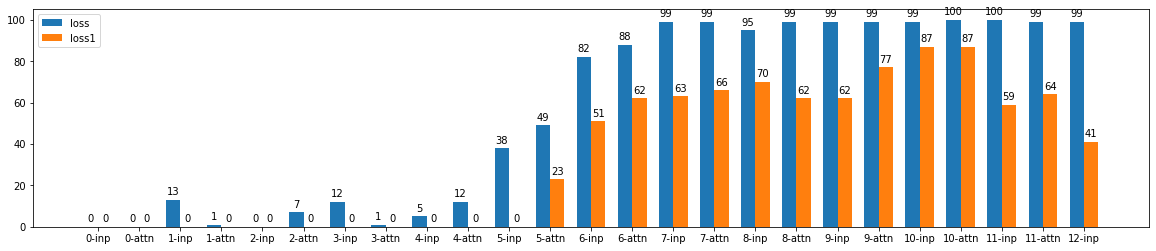

In [616]:
ffn_w = 0
results = []
for i in range(0, layer1 + 1):
    h1 = hidden_states[i] - hidden_states[0]*1
    residual = None #or hidden_states[layer1][:, arrow_positions]
    losses = [tgt_attn_loss(h1, attn, residual=residual, ffn_w=ffn_w) for attn in [_attn1, attn1]]
    results.append(('%d-inp' % i, losses[0], losses[1]))
    if i < layer1:
        losses = [tgt_attn_loss(h1 + attn_outputs[i], attn, residual=residual, ffn_w=ffn_w) 
                  for attn in [_attn1, attn1]]
        results.append(('%d-attn' % i, losses[0], losses[1]))
plot_tgt_attn_losses(*zip(*results))

10 tensor(0.2207, grad_fn=<MeanBackward0>)


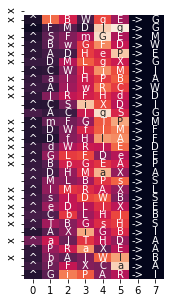

In [2149]:
a = []
tgt_h = hidden_states[layer0][0, tgt_positions]
h0 = hidden_states[layer0].view(nrows, ncols + 3, hidden_size)
for i in range(nrows):
    q = tgt_h[0:i].mean(dim=0)
    q = ln2(q).matmul(wq2.t())
    k = ln2(h0[i]).matmul(wq2.t())
#     attn1 = globalize(attentions[layer1]) * head_mask
#     attn_output1 = torch.matmul(attn1, _head_output1).sum(1)
#     q = ln2(attn_output1[:, arrow_positions[i]]).matmul(wq2.t())
#     q = ln2(_attn_output1[:, ans_positions][:, i:i+1].mean(1)).matmul(wq2.t())
#     k = key[i]
    a.append((q * k).sum(-1).unsqueeze(0))  # == torch.matmul(q, k.t())

a = torch.cat(a)
a[:, -2:] = -1000000
a = a.softmax(-1)
plot_tgt_attn(a)

In [3153]:
layer1, head1 = 12, 18
layer0, head0 = 11, 8
layer2, head2 = 13, 2  #17-4 for A[B]C->B,A*BC->B, 13-5 for reverse set diff
self0, self1, self2 = get_attn_module(blocks[layer0]), get_attn_module(blocks[layer1]), get_attn_module(blocks[layer2])

h_mask = torch.ones(hidden_size)
h_mask[top_i[0]] = 0

ln0, ln1, ln2 = blocks[layer0].ln_1, blocks[layer1].ln_1, blocks[layer2].ln_1
# mean, var = forward(blocks[layer2], 'ln1_mean_var')

wq0, wk0, wv0, wo0 = get_head_weights(layer0, head0)
wq1, wk1, wv1, wo1 = get_head_weights(layer1, head1)
wq2, wk2, wv2, wo2 = get_head_weights(layer2, head2)

In [3396]:
attn_output0, ffn_output0 = forward(blocks[layer0], ['attn_output', 'ffn_output'], exit_module=blocks[layer0],
                                    extra_tuples=[(get_attn_module(blocks[layer0]), 'hidden_states_mask', h_mask)])
head_output0 = forward(get_attn_module(blocks[layer0]), 'head_output', exit_module=blocks[layer0],
                        extra_tuples=[(get_attn_module(blocks[layer0]), 'hidden_states_mask', h_mask)])

10


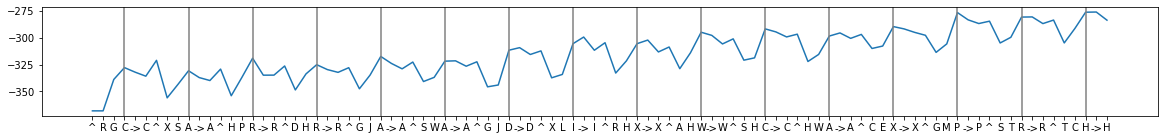

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 
 tensor(1.0000, grad_fn=<MeanBackward0>)


In [1202]:
## h1 = ln1(hidden_states[10]*0 + attn_output0 * 1 + ffn_output0 * 1)
h1 = ln1(hidden_states[layer0]*1 + attn_outputs[10]*1 + ffn_outputs[10] * 1 + attn_outputs[11] * 1 + ffn_outputs[11] * 1)

self1.head_output, self1.attn_output = None, None
self1.w = attentions[layer1]
try: _ = self1(h1, attention_mask=attention_masks[layer1])
finally:
    head_output1, attn_output1 = getdelattr(self1, 'head_output'), getdelattr(self1, 'attn_output')
    try_delattr(self1, 'w')

query = get_query(self2, ln2(hidden_states[layer1]*0 + attn_output1*1 + attn_outputs[13]*0))
# query = get_query(self2, ln2(head_output1[:, [16, 18]].sum(1)))
# query = get_query((self2, head_outputs[layer1][:, head1]))
# query = get_query(self2, attn_hidden_states[layer2])
for layer in [layer0]:#range(layer2 + 1):
    key2 = get_key(self2, ln2(hidden_states[layer]))
#     key2 = get_key(self2, ln2(attn_outputs[9]))
    logits = (query * key2).sum(dim=-1)
    print(layer)
    _ = test(None, None, logits=logits, always_show=True)

In [73]:
emb = all_embs[task_name][key]
emb_attr = all_attrs[task_name][key + str(int(pred_attn))]

In [2881]:
layer0 = 10
# layer, head = 10, 8  # ABC->B, ABC->A(pred_attn<12-18), ABC->C(only pred_attn), find lowercase, set diff2(only pred_attn)
layer, head = 12, 18 # 12-16, 12-18, 12-1 ABC->A, ABC,AXC->X, set diff2, set diff
layer2, head2 = 13, 2  # ABC->B, ABC->A, ABC->C, ABC,AXC->X, set diff, set diff2(<13-12), find lowercase(<15-8)
# layer2, head2 = 15, 8  # 15-8, find lowercase
# layer2, head2 = 13, 12  # set diff2, ABC,AXC->X(<13-2)

In [483]:
positions = tgt_positions[1:]
offsets = [torch.zeros_like(positions) - 1, torch.zeros_like(positions), torch.zeros_like(positions) + 1]
labels = numpy(torch.cat(offsets))
for layer in range(layer2):
    for head in range(H):
        emb = numpy(torch.cat([attn_outs[layer][0, head, positions + offset] for offset in offsets]))
#         emb = numpy(torch.cat([head_outputs[layer][0, head, positions + offset] for offset in offsets]))
        head_output = head_outputs[layer][:, head]
        if cluster(emb, labels)[0]:# and test(head_output, always_show=False) is not None:
#         if test(head_output, always_show=False) is not None:
            visualize_by_pca(emb, labels)
#             attn = globalize(attentions[layer])[0, head]
#             plot_attn(attn)
            print(layer, head)

(tensor([0.0174, 0.0392, 0.0546, 0.0641, 0.0408, 0.2807, 0.1289, 0.1209, 0.0977],
        grad_fn=<IndexBackward>),
 tensor(0.8444, grad_fn=<SumBackward0>))

(tensor([0.6571, 0.1062, 0.3671, 0.5548, 0.2617, 0.7426, 0.6988, 0.5396, 0.8236,
         0.6873], grad_fn=<SelectBackward>),
 tensor(0.5439, grad_fn=<MeanBackward0>))

(tensor([1.1355e-16, 3.7752e-13, 7.8185e-12, 6.1335e-10, 5.1372e-08, 3.3332e-06,
         3.1391e-04, 5.4327e-03, 1.5451e-01, 5.4892e-01],
        grad_fn=<IndexBackward>),
 tensor(0.0709, grad_fn=<MeanBackward0>))

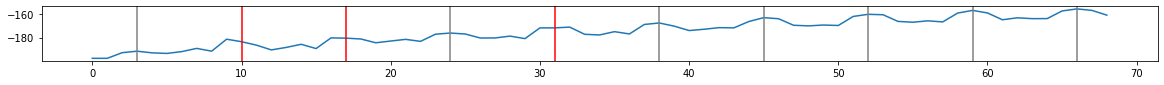

True

In [2023]:
layer0, head0 = 10, 1 #11-14  10-1
h_mask2 = torch.ones(hidden_size)
h_mask2[top_i[:]] = 0

attn_mask = torch.ones(H, seq_len, hidden_size // H)
# attn_mask[:, :] = 0
# attn_mask[8, :] = .1
m = get_attn_module(blocks[layer2])
outputs = forward(get_attn_module(blocks[layer0]), 'attn_mask', attn_mask, exit_module=blocks[layer2],
                 extra_tuples=[(m, 'return_attn_logits', True), #(m, 'hidden_states_mask', h_mask2),
#                                (get_attn_module(blocks[10]), 'hidden_states_mask', h_mask2),
                               (get_attn_module(blocks[layer1]), 'w', attentions[layer1])
                              ])

probs0 = outputs.attentions[layer1][0, head1, src, ans_positions[:-1]]
probs0, probs0.sum()
logits = globalize(outputs.attentions[layer2])[0, head2, src, : src + 1]
probs = logits[cand_positions].view(-1, n_candidates).softmax(-1)[:, task_name2idx[task_name]]
probs, probs.mean()
probs = logits.softmax(-1)[tgt_positions]
probs, probs.mean()
test(None, None, logits=logits)

tensor([[0.0066, 0.0076, 0.1356, 0.0835, 0.2636, 0.0631, 0.2177]],
       device='cuda:2')
tensor([0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143],
       device='cuda:2')
{'44 a': 0.3398, '42 ^': 0.2043, '43 Y': 0.1879, '38 I': 0.0659, '41 v': 0.0539}


{'Ġa': 0.3382, 'Ġv': 0.2697, 'ĠY': 0.0545, 'Ġu': 0.042, 'Ġy': 0.0365}

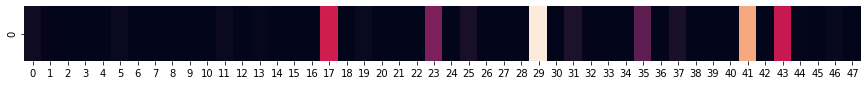

In [261]:
m = blocks[layer].attn.attention
mask = torch.ones(H, seq_len, seq_len)
# mask[:, src] = 0
mask[:] = 0
mask[head, src] = 0.1
_ = mask.requires_grad_(True)
# m.attn_mask = mask

# scaled_attn = attentions[layer] * mask.to(model.device)
# _ = scaled_attn.requires_grad_(True)
# m.w = scaled_attn
try:
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
    attn = outputs.attentions[layer]
    _ = plt.figure(figsize=(15, 1))
    _ = sns.heatmap(numpy(attn[:, head, src, :]), cbar=False)
    print(attn[:, head, src, ans_positions[:-1]])
    
    attn[:] = 0
#     attn[0, head, src] = 0
    attn[0, head, src, ans_positions[:-1]] = 0.1 / len(ans_positions[:-1])
#     i = random.randint(0, attn.size(3) - 1); i
#     attn[0, head, src] = 0.1 / attn.size(3)
    print(attn[0, head, src, ans_positions[:-1]])
    m.w = attn
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
#     outputs = model(**inputs, output_attentions=True)
finally:
#     m.attn_mask = None
    m.w = None
# y = outputs.logits.softmax(-1)[:, src, pred_label]
# mask_grad = torch.autograd.grad(torch.unbind(y), mask)[0]
# attn_grad = torch.autograd.grad(torch.unbind(y), scaled_attn)[0]
    
attn = globalize(outputs.attentions[layer2])[0, head2, src]
print(show_topk(*attn.topk(5), indices_fn=append_tokens_to_positions))
probs = outputs.logits[0, src].softmax(-1)
show_topk(*probs.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

In [209]:
attn_grad[0, head - 2].mean()

tensor(0.0001, device='cuda:2')

In [169]:
attn_grad.size()
attn_grad2.size()
(attn_grad2[4:5] - attn_grad).abs().max()
attn_grad[0, head, src, ki]
attn_grad2[4, head, src, ki]

torch.Size([1, 20, 72, 72])

torch.Size([10, 20, 72, 72])

tensor(6.2585e-05, device='cuda:2')

tensor([-0.2539, -0.2229, -0.2132, -0.1997, -0.1915, -0.1745, -0.1862],
       device='cuda:2')

tensor([-0.2539, -0.2229, -0.2132, -0.1997, -0.1915, -0.1745, -0.1862],
       device='cuda:2')

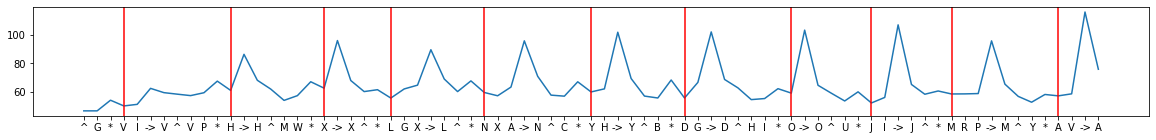

[0.017 0.002 0.011 0.    0.    0.001 0.    0.044 0.    0.088 0.13 ] 
 tensor(0.0266, grad_fn=<MeanBackward0>)


In [3504]:
qh = ln2(hidden_states[layer1]*0 + attn_output1*1 + attn_outputs[13]*1)[:, src:src+1]
kh = attn_hidden_states[layer2]
# kh = ln2(attn_outputs[9])
logits = (qh * kh).sum(dim=-1).squeeze(0)
_ = test(None, None, logits=logits, always_show=True)

In [11]:
texts = {
    'find lowercase': '''
X C e -> e
S f Z -> f
K y N -> y
q M N -> q
u S N -> u
S v Y -> v
v I J -> v
Y a N -> a''',
    'AbC->B': '''
X C e -> E
S f Z -> F
K y N -> Y
q M N -> Q
u S N -> U
S v Y -> V
g I J -> G
Y a N -> A
L n J -> N
d H I -> D
Z r C -> R
U S t -> T
K r A -> R
I G m -> M
t O X -> T''',  # failed, but GPT-3 can with low prob
    'set diff': '''
G L C, G L -> C
Y P J, Y P -> J
E S A, S A -> E
U P W, U P -> W
W Z A, W A -> Z
Z Q J, Z J -> Q
C Y L, Y L -> C
C K Z, C Z -> K
K O Q, O Q -> K
K O N, K N -> O
R U P, R P -> U
X C J, X C -> J
B G V, G V -> B
H V L, H V -> L
J K M, J M -> K
N W K, W K -> N
F B D, F B -> D''',
    'find majority': '''
n d d -> d
f f d -> f
e b e -> e
s q s -> s
d d o -> d
c e e -> e
g t g -> g
i i w -> i''', # basically failed
    'find special': '''
n d d -> n
f f d -> d
e b e -> b
s q s -> q
d d o -> o
c e e -> c
g g t -> t
w i i -> w''',  # failed, GPT-3 failed, too
    'find special2': '''
n d d d -> n
f f f d -> d
e b e e -> b
s s q s -> q
d d d o -> o
e c e e -> c
g g g t -> t
w i i i -> w''',  # failed, but GPT-3 can
    'ABC,AXC->X': '''
D O Q, K O Q -> K
K H N, K O N -> O
R X P, R U P -> U
X C G, X C J -> J
Z G V, B G V -> B
H V T, H V L -> L
J E M, J K M -> K
A W K, U W K -> U
F B Y, F B D -> D''',
    'reverse set diff': '''
O Q, K O Q -> K
K N, K O N -> O
R P, R U P -> U
X C, X C J -> J
G V, B G V -> B
H V, H V L -> L
J M, J K M -> K
W K, N W K -> N
F B, F B D -> D''',
    'set diff2': '''
Z Y, y -> z
K B, b -> k
N E, e -> n
J S, j -> s
O W, o -> w
F R, f -> r
J S, s -> j
N O, o -> n
P R, p -> r''',
    'find next': '''
W S D L, S -> D
F M W Q, F -> M
T W A V, A -> V
U V N M, N -> M
S D N O, S -> D
A S B T, S -> B
H W L Z, H -> W
C L J O, J -> O
T B A E, B -> A
L G C K, L -> G
G B S O, G -> B
K Y F O, F -> O
V Q U S, V -> Q
S E Y P, Y -> P
X D A U, A -> U
T L M N, L -> M
U O Y I, O -> Y''',  # failed, GPT-3 failed too
    'antonym': '''
big -> small
low -> high
fast -> slow
dark -> light
long -> short''',
}

In [ ]:
try:
#     with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
#     attn = outputs.attentions[layer]
#     print(attn[0, head, src, ans_positions[:-1]])
#     attn[0, head, src] = 0
#     attn[0, head, src, ans_positions[-8]] = 1
#     print(attn[0, head, src, ans_positions[:-1]])
#     m.w = attn
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
finally:
    m.attn_mask = None
#     m.w = None

In [258]:
def norm(tensor): return round(tensor.abs().mean().item(), 4)
hidden_states.mean(), hidden_states.std()
for l in range(layer, layer2):
    print(norm(hidden_states), end=' ')
    hidden_states = hidden_states + h[l].attn_output
    print(norm(h[l].attn_output), norm(hidden_states), hidden_states.mean(), hidden_states.std())
    print(norm(hidden_states), end=' ')
    hidden_states = hidden_states + h[l].ffn_output
    print(norm(h[l].ffn_output), norm(hidden_states), hidden_states.mean(), hidden_states.std())

(tensor(-0.7157, device='cuda:2'), tensor(17.1320, device='cuda:2'))

2.3035 0.7521 2.545 tensor(-0.7262, device='cuda:2') tensor(17.2453, device='cuda:2')
2.545 0.7547 2.7227 tensor(-0.7361, device='cuda:2') tensor(17.7049, device='cuda:2')
2.7227 0.7046 2.9372 tensor(-0.7366, device='cuda:2') tensor(17.8712, device='cuda:2')
2.9372 0.8032 3.1048 tensor(-0.7600, device='cuda:2') tensor(18.7369, device='cuda:2')
3.1048 0.8814 3.2894 tensor(-0.7694, device='cuda:2') tensor(18.9570, device='cuda:2')
3.2894 0.8759 3.2595 tensor(-0.7893, device='cuda:2') tensor(19.1697, device='cuda:2')


In [257]:
_hidden_states = h[layer2].ln_1(hidden_states)
try:
    with torch.no_grad(): _, attn = am2(am2_hidden_states, am2_attention_mask, output_attentions=True, q_hidden_states=_hidden_states)
finally: am2.q_hidden_states = None
attn = globalize(attn)
attn[0, head2, -1].topk(5)

torch.return_types.topk(
values=tensor([0.4904, 0.3162, 0.0501, 0.0432, 0.0416], device='cuda:2'),
indices=tensor([42, 43, 36, 44, 46], device='cuda:2'))

In [326]:
with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
attn = globalize(outputs.attentions[layer2])[0, head2, -1]
show_topk(*attn.topk(5), indices_fn=append_tokens_to_positions)
probs = outputs.logits[0, -1].softmax(-1)
show_topk(*probs.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

for l in range(layer, layer + 1):
    mask_tgt_indices = [41, 35, 29, 23, 17, 11, 5]
    excluded_src_indices = [seq_len - 1] #if l == layer else []
    attn = outputs.attentions[l]
    if attn.dim() == 5:
        attn = attn[:, 0, :, :, -seq_len:] # (bsz, num_blokcs, H, seq_len, window_size + seq_len) -> (bsz, H, seq_len, seq_len)
#     for hd in range(H):
#         for src_idx in range(seq_len):
#             if hd != head and src_idx in excluded_src_indices:
#                 attn[:, hd, src_idx] = 0
    for hd in range(H):
        for src_idx in range(seq_len):
            for tgt_idx in range(seq_len):
                if hd == head and src_idx not in excluded_src_indices and tgt_idx in mask_tgt_indices:
                    attn[:, hd, src_idx, tgt_idx] = 0
    h[l].attn.attention.w = outputs.attentions[l]
try:
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
finally:
    for l in range(layer, layer2):
        h[l].attn.attention.w = None
attn = globalize(outputs.attentions[layer2])[0, head2, -1]
show_topk(*attn.topk(5), indices_fn=append_tokens_to_positions)
probs = outputs.logits[0, -1].softmax(-1)
show_topk(*probs.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

{'44 E': 0.7865, '43 V': 0.1431, '38 K': 0.0355, '45 H': 0.0323, '37 A': 0.001}

{'ĠE': 0.8562, 'ĠH': 0.1216, 'ĠV': 0.0133, 'ĠD': 0.0009, 'ĠI': 0.0007}

{'28 ->': 0.6616,
 '40 ->': 0.3003,
 '22 ->': 0.0244,
 '34 ->': 0.013,
 '16 ->': 0.0003}

{'ĠT': 0.2914, 'ĠC': 0.1015, 'ĠL': 0.0839, 'ĠY': 0.0793, 'ĠE': 0.0643}

In [70]:
head_attrs = all_attrs['A B C D -> a'].sum(dim=(2, 3))
# head_attrs = attrs.sum(dim=(2, 3))

values, indices = head_attrs[:, :].view(-1).topk(10)
indices = unravel_index(indices, head_attrs.size())
top_heads = [(l, h, round(v, 8)) for l, h, v in zip(
    indices[0].tolist(), indices[1].tolist(), values.tolist())]
top_heads

[(17, 1, 1.08707237),
 (19, 21, 1.00648546),
 (21, 13, 0.78149551),
 (17, 10, 0.68284625),
 (17, 15, 0.63359404),
 (18, 18, 0.62241864),
 (22, 15, 0.52263898),
 (20, 5, 0.45230082),
 (19, 17, 0.36873266),
 (21, 4, 0.33636701)]

In [26]:
inputs = tokenizer.encode_plus(_text, return_tensors='pt')
outputs = model(**inputs, output_attentions=True)

logits = outputs.logits if hasattr(outputs, 'logits') else outputs[0]
y = logits[0, -1].max()
attentions = outputs.attentions if hasattr(outputs, 'attentions') else outputs[-1]
for a in attentions: a.retain_grad()
model.zero_grad()
y.backward()

# attns = torch.cat(attentions)
grads = torch.cat([a.grad for a in attentions])
attrs2 = attns * grads

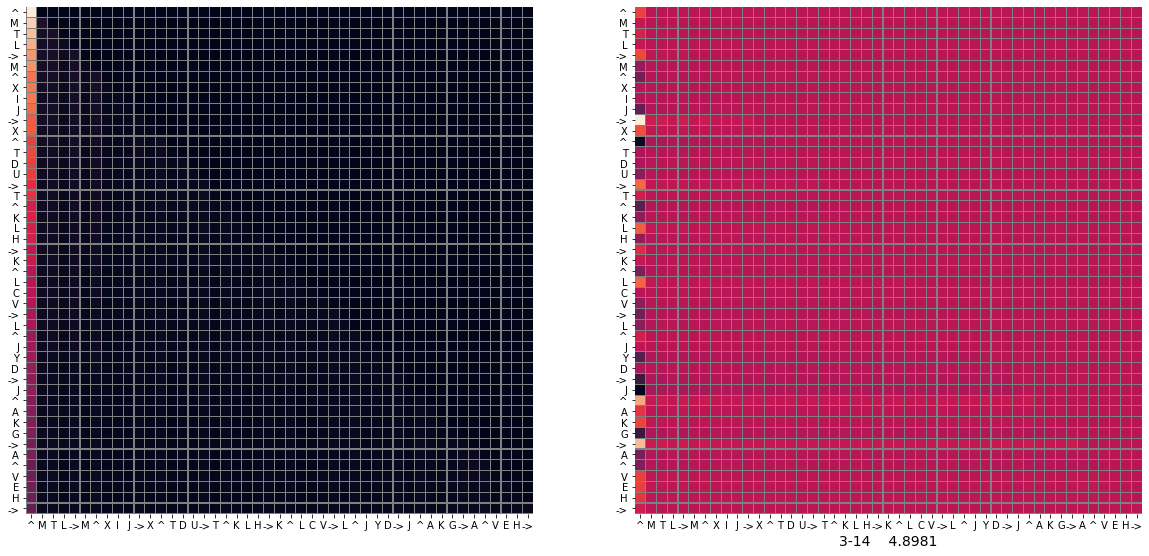

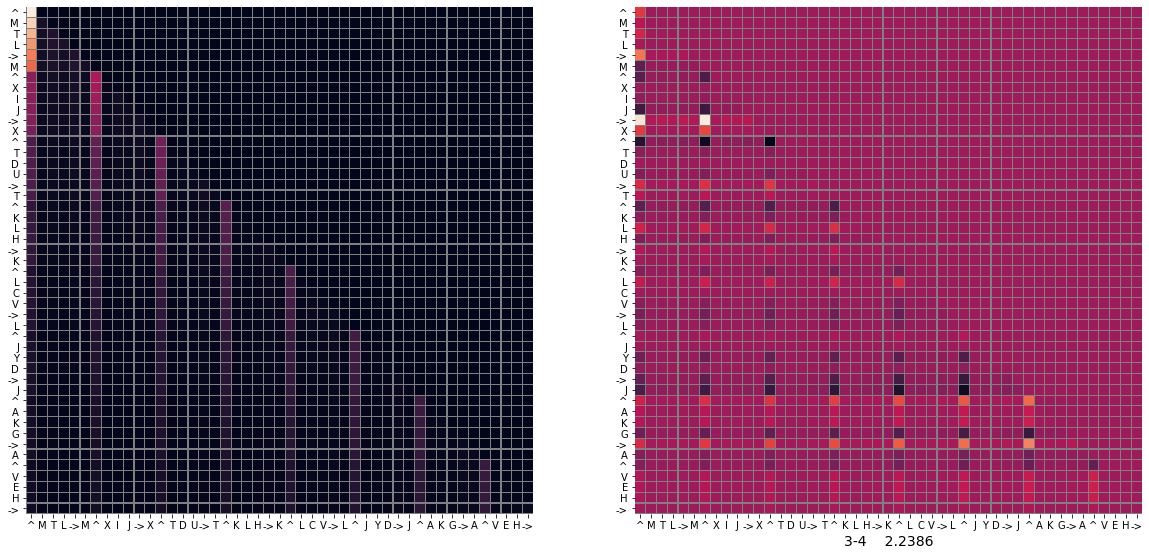

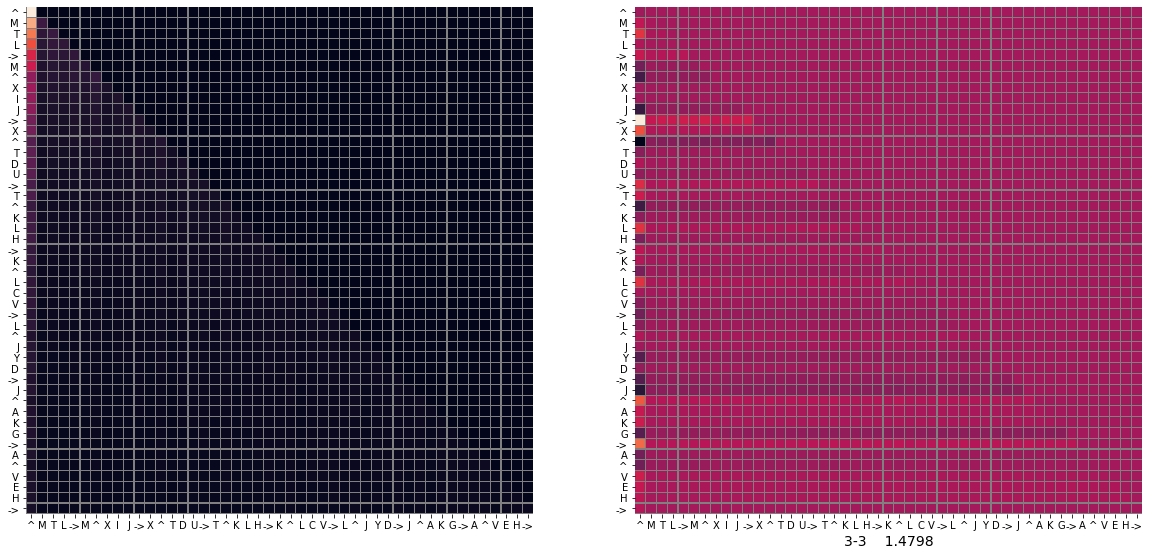

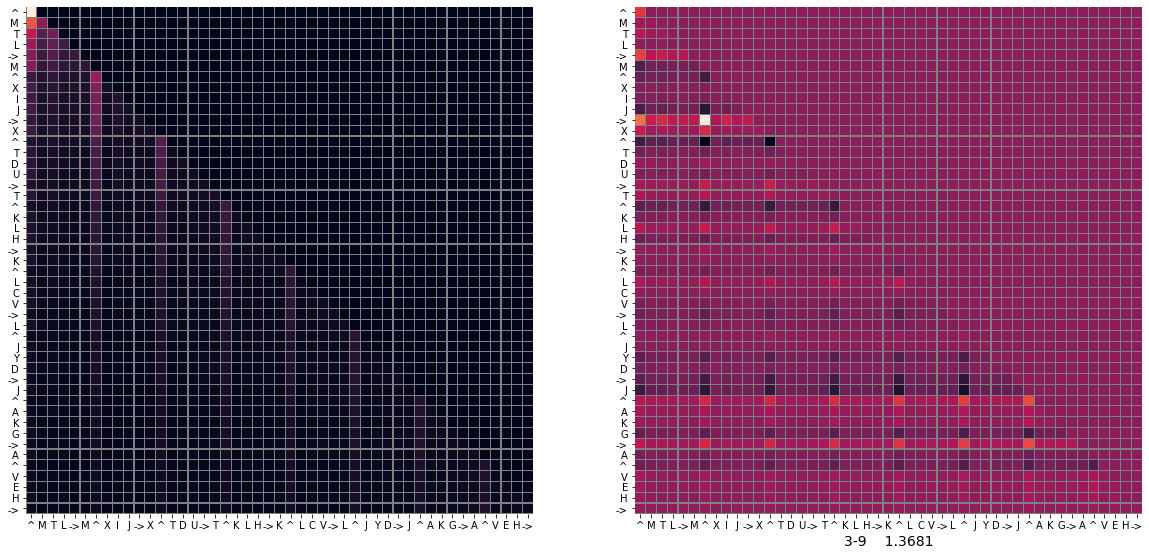

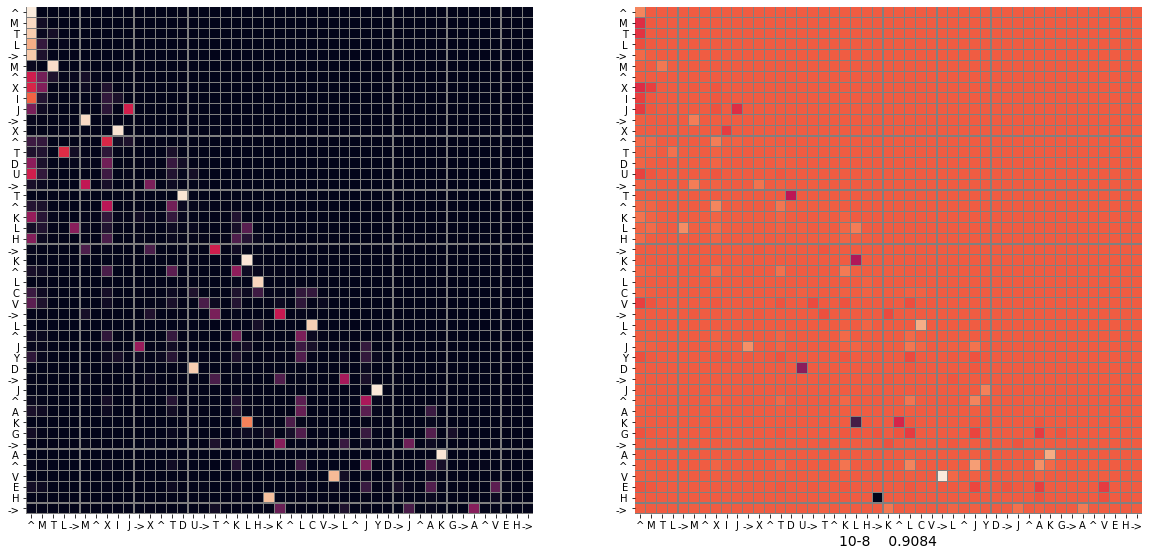

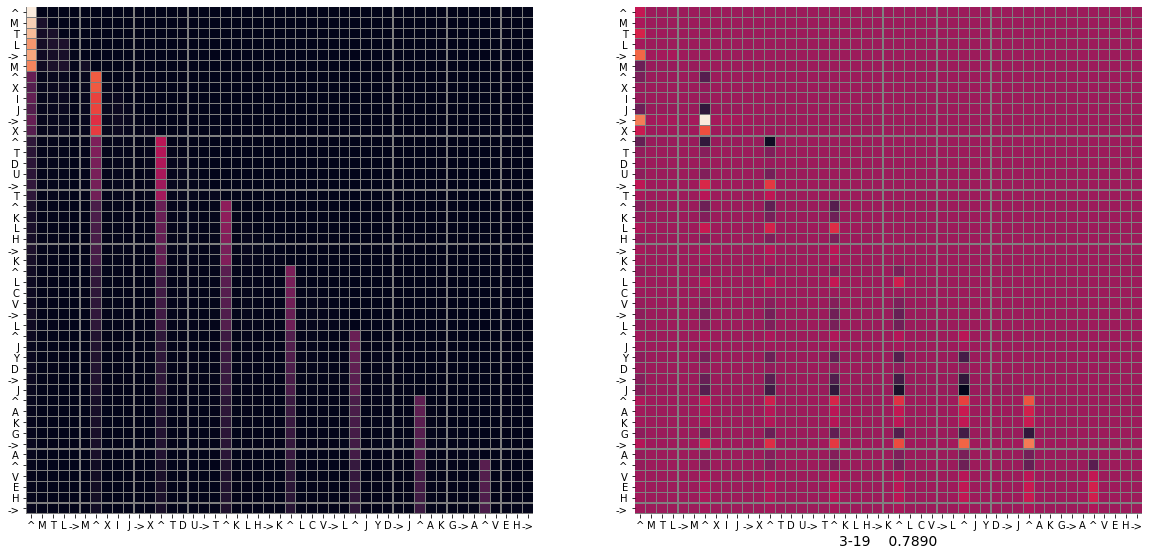

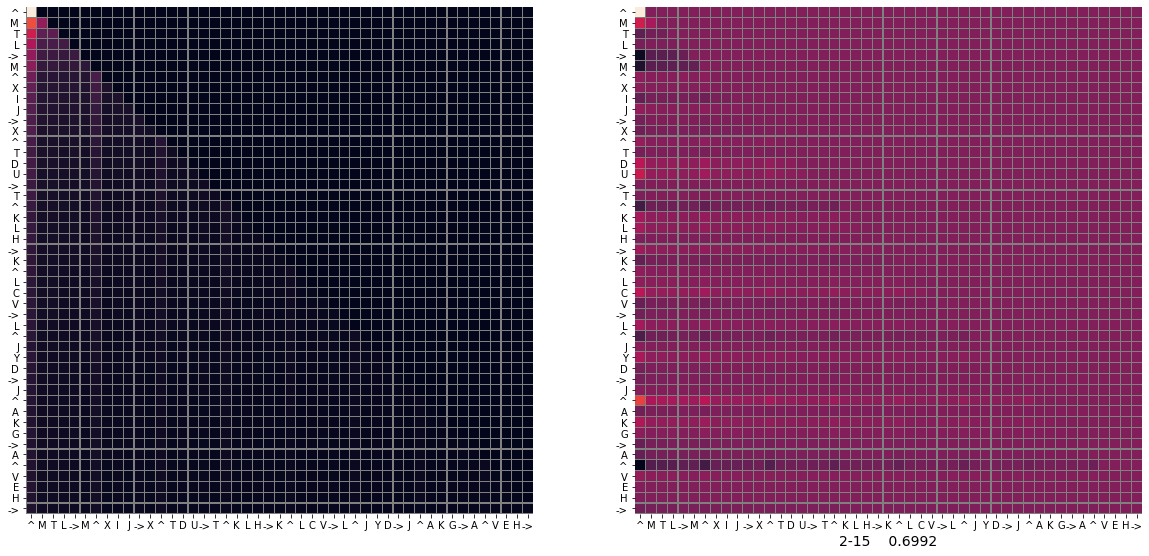

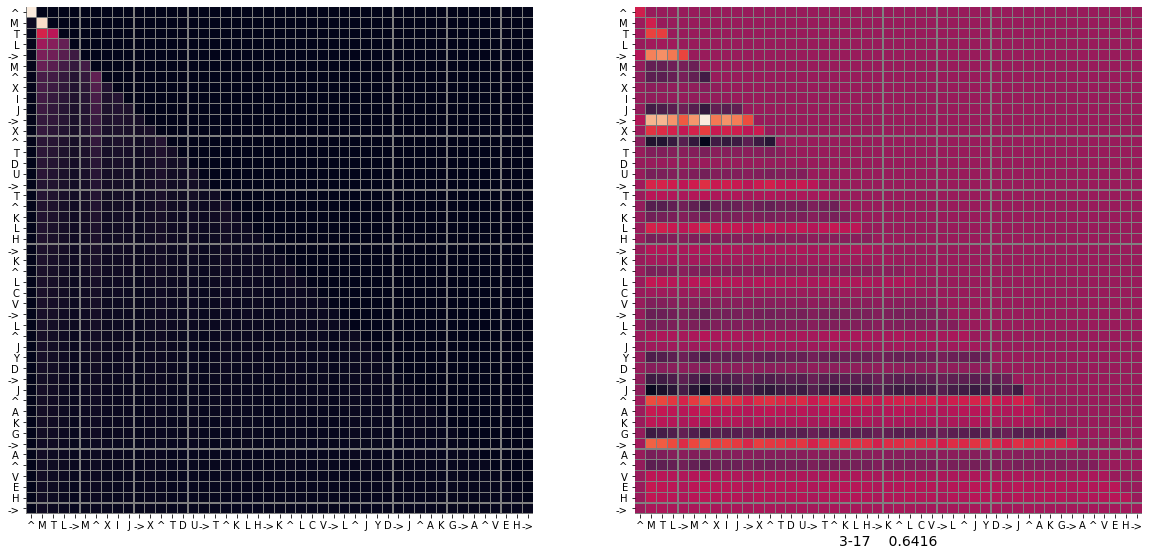

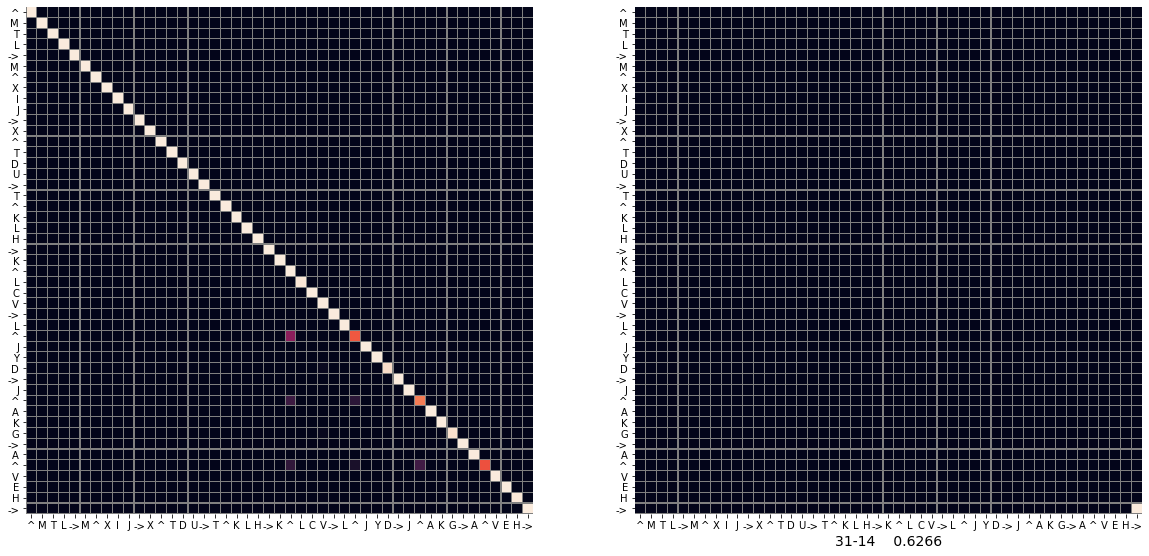

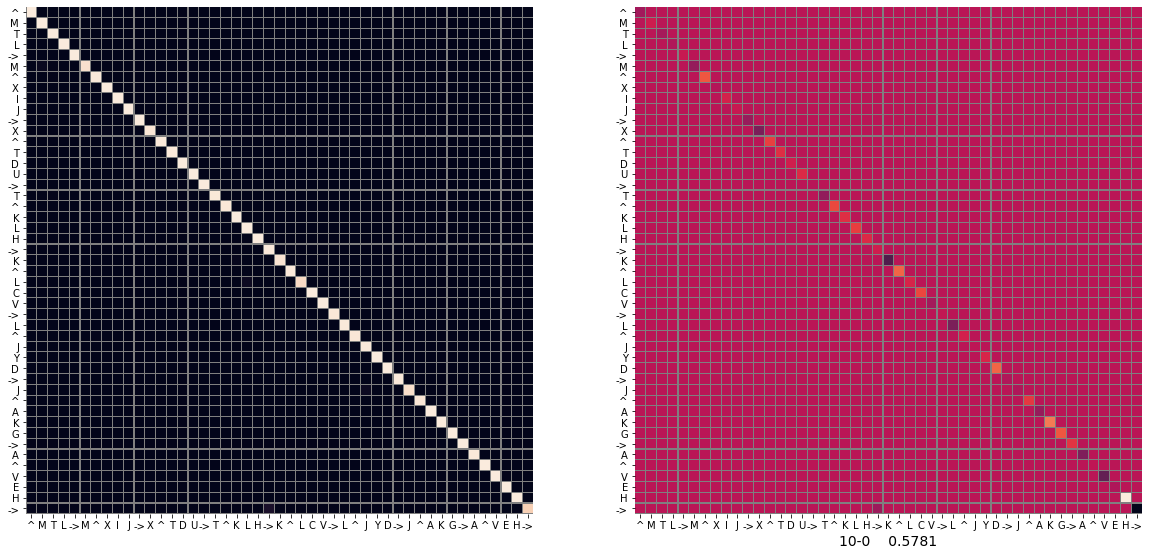

In [259]:
for i in range(len(top_heads)):
    layer, head, v, _ = top_heads[i]
    if layer in [0, 1, ]: continue
#     layer, head, v = 30, 10, 1.
    fig, axs = plt.subplots(1,2,sharey=False, figsize=(10 * 2, 10))
    for i, (a, _ax) in enumerate(zip([attns, attrs], axs)):
        a = a[layer][head].detach().cpu()
        a, annot = ((a * 100).long(), True) if i == -1 else (a, False)
        res = sns.heatmap(a, square=True, cbar=False, annot=annot, fmt='d', linewidths=0.1, linecolor='grey', 
                          xticklabels=tokens, yticklabels=tokens, ax=_ax)
        _ = res.set_xticklabels(res.get_xmajorticklabels(), fontsize=9+3-2, rotation=0)
        _ = res.set_yticklabels(res.get_ymajorticklabels(), fontsize=9+3-2, rotation=0)
        _ = plt.xlabel('%d-%d    %.4f' % (layer, head, v), fontsize=14)

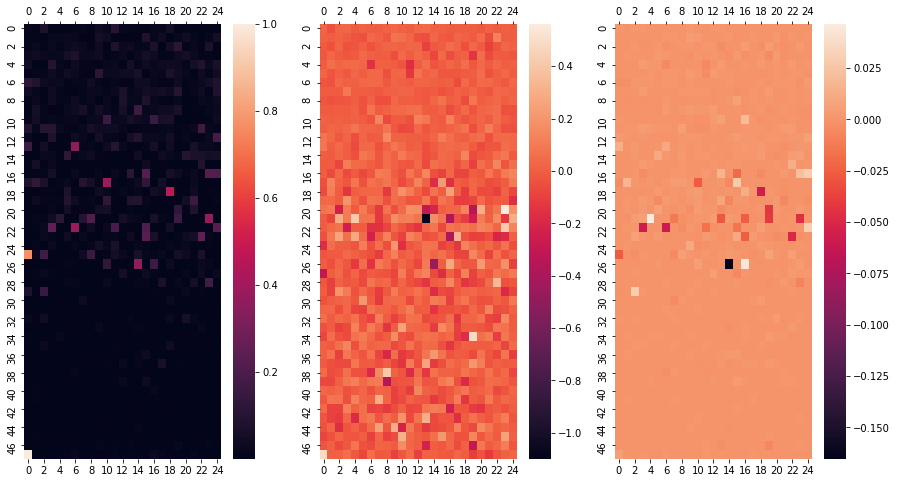

In [555]:
n_rows, n_cols = 1, 3
fig, axs = plt.subplots(n_rows, n_cols, sharey=False, figsize=(5 * n_cols, 2 * 4 * n_rows))
A = [attns, grads, attrs]

for row in range(n_rows):
    for col in range(n_cols):
        ax = axs[row][col] if row > 1 else axs[col]
        a = A[col][:, :, src,tgt].detach()
        if col == 0: a[-1, 0] = 1.
#         fig = plt.subplots(1,1,sharey=False, figsize=(5 , 8))
        ax = sns.heatmap(a, ax=ax)
        ax.tick_params(top=True, labeltop=True)

In [383]:
logits = outputs.logits if hasattr(outputs, 'logits') else outputs[0]
values, indices = logits[0, -1].softmax(dim=-1).topk(5)
list(zip(tokenizer.convert_ids_to_tokens(indices), values.tolist()))

In [132]:
input_ids = tokenizer.encode_plus(_text)['input_ids']
print(tokenizer.convert_ids_to_tokens(input_ids))
outputs = model.generate(torch.LongTensor([input_ids]).to(model.device))
print(_text, tokenizer.decode(outputs[0]))

input_ids = input_ids[: -3] + input_ids[-2:]
print(tokenizer.convert_ids_to_tokens(input_ids))
outputs = model.generate(torch.LongTensor([input_ids]).to(model.device))
print(_text, tokenizer.decode(outputs[0]))

['▁Big', '▁and', '▁small', '▁are', '<extra_id_0>', '▁', '.', '</s>']
Big and small are <extra_id_0> . <pad> <extra_id_0> welcome<extra_id_1>.</s>
['▁Big', '▁and', '▁small', '▁are', '<extra_id_0>', '.', '</s>']
Big and small are <extra_id_0> . <pad> <extra_id_0> welcome<extra_id_1> welcome.</s>


In [342]:
texts = [
    'Big is to small as fast is to _',
    'Bread is to eat as gun is to _',
    'big: small, fast: _',
    'bread: eat, gun: _ .',
    'flower: fragrant, fire: hot, bread: delicious, gun: _ ',
    'Big and small are _ .',
    'What is twice 3? _.',
    'What is the half 6? _.',
    'There is a sequence: 3, 5, 2, 7. The number immediately precedes 5 is _.',  # :)
    'There is a sequence: 3, 5, 2, 7. The number immediately follows 5 is _.',  # :(
    'There is a sequence: 3, 5, 2, 7. The number between 5 and 7 is _.',
    'There is a sequence of numbers: 3, 5, 2, 4. _ is the first number.',
    'There is a sequence of numbers: 3, 5, 2. The reversed sequence is _.',
    '''There is a sequence of numbers: 5, 1, 6, 3. The second number is 1.
There is a sequence of numbers: 3, 7, 2, 4. The second number is _.''',
    '''There is a sequence of letters: e, c, b, a. The last letter is a.
There is a sequence of letters: f, d, b, g. The last letter is _.''',
    '''The uppercase of c is C. The uppercase of f is _.''',
    '''The successor of 3 is 4. The successor of 8 is _.''',
    '''The successor of 3 is 4. The successor of _ is 6.''',
#     '''The predecessor of 3 is 2. The predecessor of 5 is 4. The predecessor of 6 is _''',
#     '''The previous integer of 4 is 3. The previous integer of 3 is _.''',
#     '''3 minus 1 equals 2. 5 minus 1 equals _.''',
    '''If 2 changes to 3, 5 changes to 6, then _ changes to 9''',
    '''If 2 changes to 20, 3 changes to 30, then 5 changes to _''',
    '''2 -> 3, 4 -> 5, 5 -> 6, 9 -> _.''',
    '''3 -> 2, 5 -> 4, 6 -> 5, 9 -> _''',
    '''9 -> 8, 7 -> 6, 6 -> 5, 2 -> _.''',
    '''3 is to _ as 4 is to 8 and 5 is to 10.''',
#     '''6 : _ :: 5 : 10 :: 7 : 14 :: 8 : 16.''',
#     '''a is to _ as f is to g, h to i, i to j, s to t.''',
#     '''c is to _ as f is to e, h to g, j to i.''',
    '''c is to _ as j is to i, h to g, f to e.''',
#     '''Twice 3 is 6, twice 4 is _.''',
#     '''Half of 4 is 2, half of 6 is _.''',

# '''Shall I compare thee to a summer's day?
# Thou''',
# '''Do not go gentle into that good night,
# Old age should burn and rave at close of day;
# Rage'''
]